# RealWaste Dataset: Data Preparation and Dataloader Implementation

This notebook demonstrates how to prepare the *RealWaste* dataset for training machine learning models and how to effectively train and test various ML models. The *RealWaste* dataset contains images of various waste types categorized into nine classes, which can be used for tasks like waste classification and recycling optimization. 

The workflow includes:
1. **Custom Dataset Class**: To load and process the images from the dataset directory.
2. **Data Transformation and augmentation**: Includes resizing images to `224x224` and converting them to tensors.
3. **Data Splitting**: Randomly splits the dataset into training, validation, and test sets.
4. **Dataloader Creation**: Provides easy access to the data for model training and evaluation.

The dataset is structured as a directory containing subdirectories for each class, where each subdirectory holds images of that class. We utilize `PyTorch` for handling the dataset and loaders.

In [9]:
import os
import cv2
import pandas as pd
from sklearn.model_selection import StratifiedShuffleSplit
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import random
import numpy as np
import torch
import time

# Configuration
BATCH_SIZE = 64
IMG_SIZE = (224, 224)
TEST_SPLIT = 0.1
VAL_SPLIT = 0.1
RANDOM_SEED = 42
DATA_DIR = '/kaggle/input/realwaste/realwaste-main/RealWaste'

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(RANDOM_SEED)

class RealWasteDataset(Dataset):
    def __init__(self, root_dir=None, data=[], labels=[], size=None, transforms=[], transform=None, print_info=True):
        """
        Args:
            root_dir (str): Path to the dataset directory.
            transform (callable, optional): Optional transform to be applied to an image.
        """
        self.root_dir = root_dir
        self.transforms = transforms
        self.transform = transform
        self.data = data
        self.labels = labels
        self.image_sizes = {} if size is None else {size} # Dictionary to store image size counts
        
        # Class mapping
        self.classes = {
            0: 'Cardboard',
            1: 'Food Organics',
            2: 'Glass',
            3: 'Metal',
            4: 'Miscellaneous Trash',
            5: 'Paper',
            6: 'Plastic',
            7: 'Textile Trash',
            8: 'Vegetation'
        }

        start = time.time()
        
        if root_dir is not None:
            
            for label, label_name in self.classes.items():
                class_dir = os.path.join(self.root_dir, label_name)
                if not os.path.exists(class_dir):
                    continue
                for img_name in os.listdir(class_dir):
                    img_path = os.path.join(class_dir, img_name)
                    
                    try:
                        with Image.open(img_path) as img:
                            img.verify()  # Verifies the file integrity without loading the full image
                            img_size = img.size  # Access metadata
                            self.image_sizes[img_size] = self.image_sizes.get(img_size, 0) + 1
                    except Exception as e:
                        print(f"Error loading image {img_path}: {e}")
                        continue
                    
                    self.data.append(img_path)
                    self.labels.append(label)
                    
        end = time.time()
        
        if print_info:
            self.print_info(round(end - start, 2))
        
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data[idx]
        label = self.labels[idx]
        image = Image.open(img_path).convert("RGB")  # Ensures the image has 3 channels (RGB)

        if self.transforms:
            image = self.transforms[idx](image)
        elif self.transform:
            image = self.transform(image)
            
        return image, label
            
    def to_dataframe(self):
        """
        Converts the dataset to a pandas DataFrame.

        Returns:
            pd.DataFrame: DataFrame with columns 'image_path' and 'label'.
        """
        return pd.DataFrame({
            'image_path': self.data,
            'label': self.labels,
            'transformation': [self.transform for _ in range(len(self.labels))]
        })

        return image, label
        
    def print_info(self, elapsed):
        """
        Prints a summary of the dataset, including:
        - Total number of images.
        - Number of classes.
        - Count of images per class.
        - Unique image sizes and their counts.
        """
        print("----------Dataset Summary----------")
        print(f"Total images: {len(self.data)}")
        print(f"Number of classes: {len(self.classes)}")
        print("Images per class:")
        
        class_counts = {label_name: 0 for label_name in self.classes.values()}
        for label in self.labels:
            class_name = self.classes[label]
            class_counts[class_name] += 1
        
        for class_name, count in class_counts.items():
            print(f"  {class_name}: {count} images")
            
        print("\nUnique image sizes:")
        for size, count in self.image_sizes.items():
            print(f"  {size}: {count} images")

        print(f"\nLoaded in {elapsed} seconds!")

transform = transforms.Compose([
        transforms.Resize(IMG_SIZE),
        transforms.ToTensor(),  
])

full_dataset = RealWasteDataset(DATA_DIR, transform=transform)

----------Dataset Summary----------
Total images: 4752
Number of classes: 9
Images per class:
  Cardboard: 461 images
  Food Organics: 411 images
  Glass: 420 images
  Metal: 790 images
  Miscellaneous Trash: 495 images
  Paper: 500 images
  Plastic: 921 images
  Textile Trash: 318 images
  Vegetation: 436 images

Unique image sizes:
  (524, 524): 4752 images

Loaded in 5.29 seconds!


## Visualizing Class Distribution in the Training Dataset

This section provides a function to visualize the distribution of images across different classes in the training dataset. Analyzing the data distribution is crucial for detecting any potential class imbalances, which could impact the model's performance.

The `plot_class_distribution_from_dataframe` function:
- Counts the number of images for each class based on the provided dataframe.
- Maps numeric class labels to their corresponding class names using the `label_to_class` dictionary.
- Creates a bar chart to visualize the number of images per class.

Key features:
- Labels on top of each bar for easy interpretation.
- Customizable chart title and bar color for flexibility.

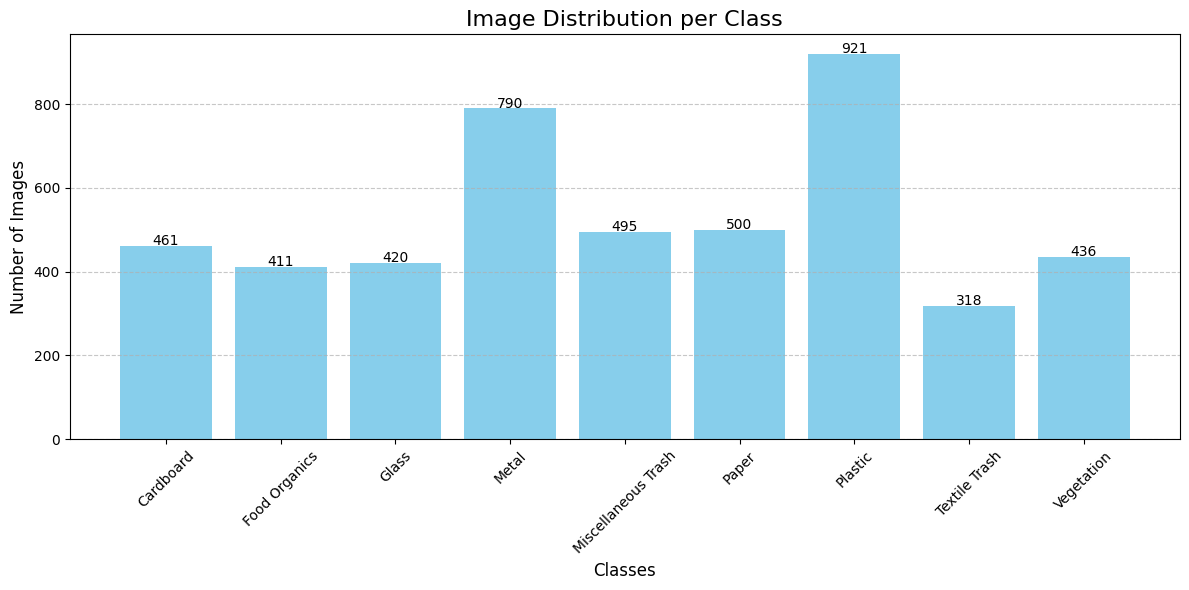

In [2]:
import matplotlib.pyplot as plt
from collections import Counter

def plot_class_distribution_from_dataframe(dataframe, label_to_class, title="Image Distribution per Class", color='skyblue'):
    """
    Generates a bar chart showing the distribution of images per class
    using data from a pandas DataFrame. Classes are ordered and displayed
    with their names.

    Args:
        dataframe (pd.DataFrame): DataFrame containing at least a 'label' column.
        label_to_class (dict): Mapping from numeric labels to class names.
        title (str): Title of the chart.
        color (str): Color of the bars.
    """
    # Count the number of images per class
    label_counts = Counter(dataframe['label'])

    # Sort classes based on their numeric labels
    sorted_labels = sorted(label_counts.items())

    # Create the bar chart
    plt.figure(figsize=(12, 6))
    bars = plt.bar(
        [label_to_class[label] for label, _ in sorted_labels],  # Class names
        [count for _, count in sorted_labels],  # Counts
        color=color
    )

    # Add count labels above each bar
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, yval + 2, str(yval), ha='center', fontsize=10, color='black')

    # Add titles and axis labels
    plt.title(title, fontsize=16)
    plt.xlabel("Classes", fontsize=12)
    plt.ylabel("Number of Images", fontsize=12)
    plt.xticks(rotation=45, fontsize=10)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Display the chart
    plt.tight_layout()
    plt.show()

# Assume 'df' is a pandas DataFrame with a column 'label'
# and 'label_to_class' is a dictionary mapping labels to class names.
plot_class_distribution_from_dataframe(full_dataset.to_dataframe(), full_dataset.classes, title="Image Distribution per Class")

## Stratified Split of the Dataset into Train, Validation, and Test Sets

This section defines a function to perform a stratified split of the dataset into training, validation, and test sets. Stratified splitting ensures that the class distribution is preserved in all subsets, which is important when working with imbalanced datasets.

The `train_val_test_split` function:
- Splits the dataset into three parts: train, validation, and test.
- Ensures that the class distribution is maintained across all splits using `StratifiedShuffleSplit`.
- Takes a random seed for reproducibility of the splits.

Key features:
- Customizable test and validation set sizes.
- Returns three separate dataframes: `train_df`, `val_df`, and `test_df`.

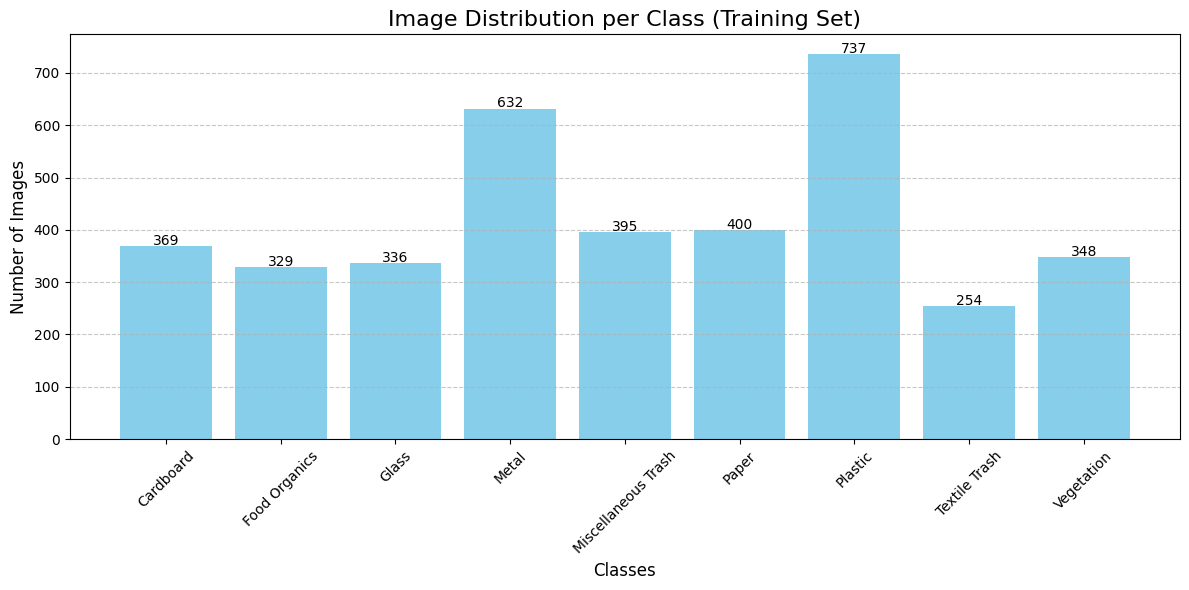

In [3]:
from sklearn.model_selection import StratifiedShuffleSplit

def train_val_test_split(full_dataframe, test_size, val_size, random_seed=RANDOM_SEED):
    """
    Performs a stratified split of the dataset into train, validation, and test sets.

    Args:
        full_dataset (RealWasteDataset): The full dataset object.
        test_size (float): Proportion of the dataset to include in the test split.
        val_size (float): Proportion of the dataset to include in the validation split.
        random_seed (int): Random seed for reproducibility.

    Returns:
        train_df (pd.DataFrame): DataFrame for the training set.
        val_df (pd.DataFrame): DataFrame for the validation set.
        test_df (pd.DataFrame): DataFrame for the test set.
    """

    # StratifiedShuffleSplit for train-test split
    stratified_split = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=random_seed)
    for train_val_idx, test_idx in stratified_split.split(full_dataframe, full_dataframe['label']):
        train_val_df = full_dataframe.iloc[train_val_idx]
        test_df = full_dataframe.iloc[test_idx]

    # Calculate the adjusted validation size relative to the remaining data
    val_adjusted_size = val_size / (1 - test_size)

    # StratifiedShuffleSplit for train-validation split
    stratified_split = StratifiedShuffleSplit(n_splits=1, test_size=val_adjusted_size, random_state=random_seed)
    for train_idx, val_idx in stratified_split.split(train_val_df, train_val_df['label']):
        train_df = train_val_df.iloc[train_idx]
        val_df = train_val_df.iloc[val_idx]

    return train_df, val_df, test_df

# Assume full_dataset is an instance of RealWasteDataset
train_df, val_df, test_df = train_val_test_split(full_dataset.to_dataframe(), test_size=TEST_SPLIT, val_size=VAL_SPLIT)

# Plot train data
plot_class_distribution_from_dataframe(train_df, full_dataset.classes, title="Image Distribution per Class (Training Set)")

## Data Augmentation in the Training Set

This section defines a function to apply data augmentation to the images in the training set. Data augmentation is used to artificially increase the size of the training dataset by generating new images from the existing ones through transformations. These transformations are randomly applied to each image, helping to improve the model's generalization.

The `augment_train` function:
- Takes a dataframe containing the training images and applies a series of transformations to augment the data.
- The function stores the transformations applied to each image in the 'transformation' column.
- Each image is augmented multiple times (specified by the `duplication_factor`).
- The resulting augmented images are added to the original dataframe.

Key features:
- Random horizontal and vertical flips.
- Random rotations and resizing.
- Support for applying multiple augmentations to each image.

Augmenting Images: 100%|██████████| 3800/3800 [00:00<00:00, 21814.60it/s]


Number of images in the original dataset: 3800
Number of images in the augmented dataset: 15200


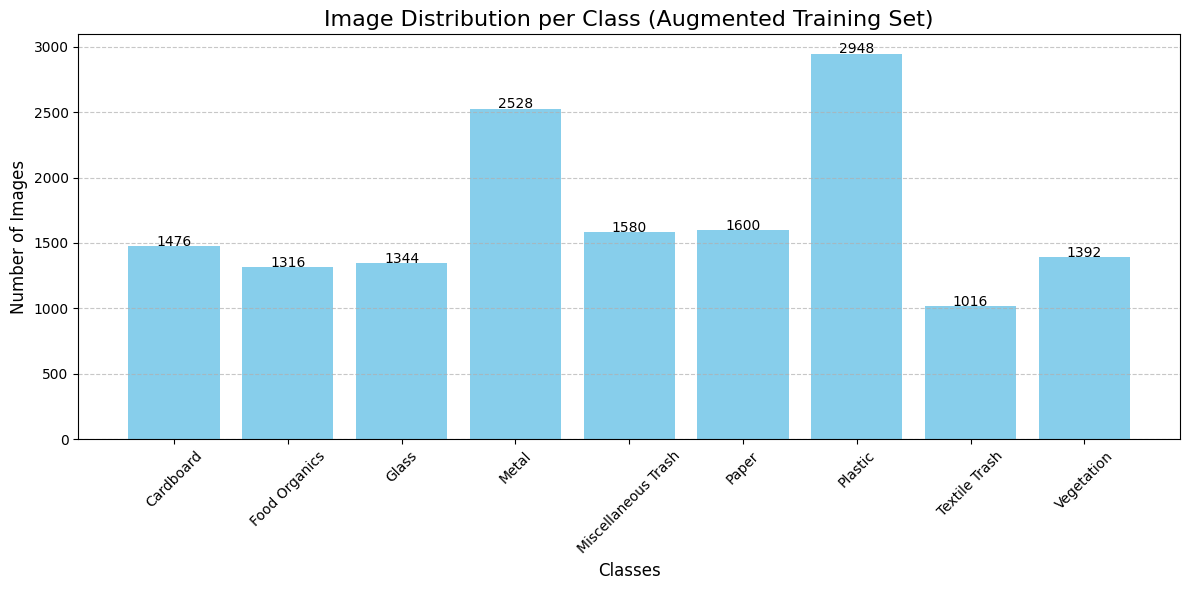

In [4]:
from tqdm import tqdm

def augment_train(train_df, duplication_factor):
    """
    Applies data augmentation to the images in the training set and updates
    the DataFrame by adding new rows for augmented images. Each augmented
    image has its corresponding transformation stored in the 'transformation' column.

    Args:
        train_df (pd.DataFrame): DataFrame containing training data with 'image_path', 'label', and 'transformation' columns.
        x (int): Number of augmented copies to create per image.
        img_size (tuple): Target size for resizing the images.

    Returns:
        pd.DataFrame: Updated DataFrame containing the original and augmented data.
    """
    # Define the augmentation pipeline
    transform_augment = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        #transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.RandomRotation(degrees=45),
        transforms.RandomResizedCrop(size=IMG_SIZE[0], scale=(0.6, 0.9)),
        transforms.Resize(IMG_SIZE),
        transforms.ToTensor()
    ])

    augmented_rows = []

    # Add progress bar for the outer loop
    for _, row in tqdm(train_df.iterrows(), total=len(train_df), desc="Augmenting Images"):
        img_path, label = row['image_path'], row['label']

        # Generate `x` augmented transformations
        for _ in range(duplication_factor):
            augmented_rows.append({
                "image_path": img_path,  # Use the same image path
                "label": label,         # Keep the label unchanged
                "transformation": transform_augment  # Store the transformation object
            })

    # Create a DataFrame from the augmented rows
    augmented_df = pd.DataFrame(augmented_rows)

    # Concatenate the original and augmented DataFrames
    combined_df = pd.concat([train_df, augmented_df], ignore_index=True)

    return combined_df


# Apply data augmentation to the train dataset
train_df_augmented = augment_train(train_df, duplication_factor=3)

# Verify the number of images
print(f"Number of images in the original dataset: {len(train_df)}")
print(f"Number of images in the augmented dataset: {len(train_df_augmented)}")

# Plot the augmented data
plot_class_distribution_from_dataframe(train_df_augmented, full_dataset.classes, title="Image Distribution per Class (Augmented Training Set)")

## Visualizing Training Images by Class

The cell below showcases examples of training images, organized by class. Each row represents a specific class, with the class name displayed in the first column. The purpose is to visually inspect the distribution and augmentation of images in the dataset.

Key Features:
- Displays a sample of images for each class from the dataset.
- Each row corresponds to a single class, with a configurable number of columns for images.
- The class names are displayed in the first column for clarity.

The `plot_training_images_by_class` function:
1. Groups images from the dataset by class labels.
2. Samples up to a specified number of images (`ncols`) for each class.
3. Creates a grid where rows represent classes and columns represent image samples.
4. Allows easy visualization of data augmentation and class distribution.

Sampling images by class...


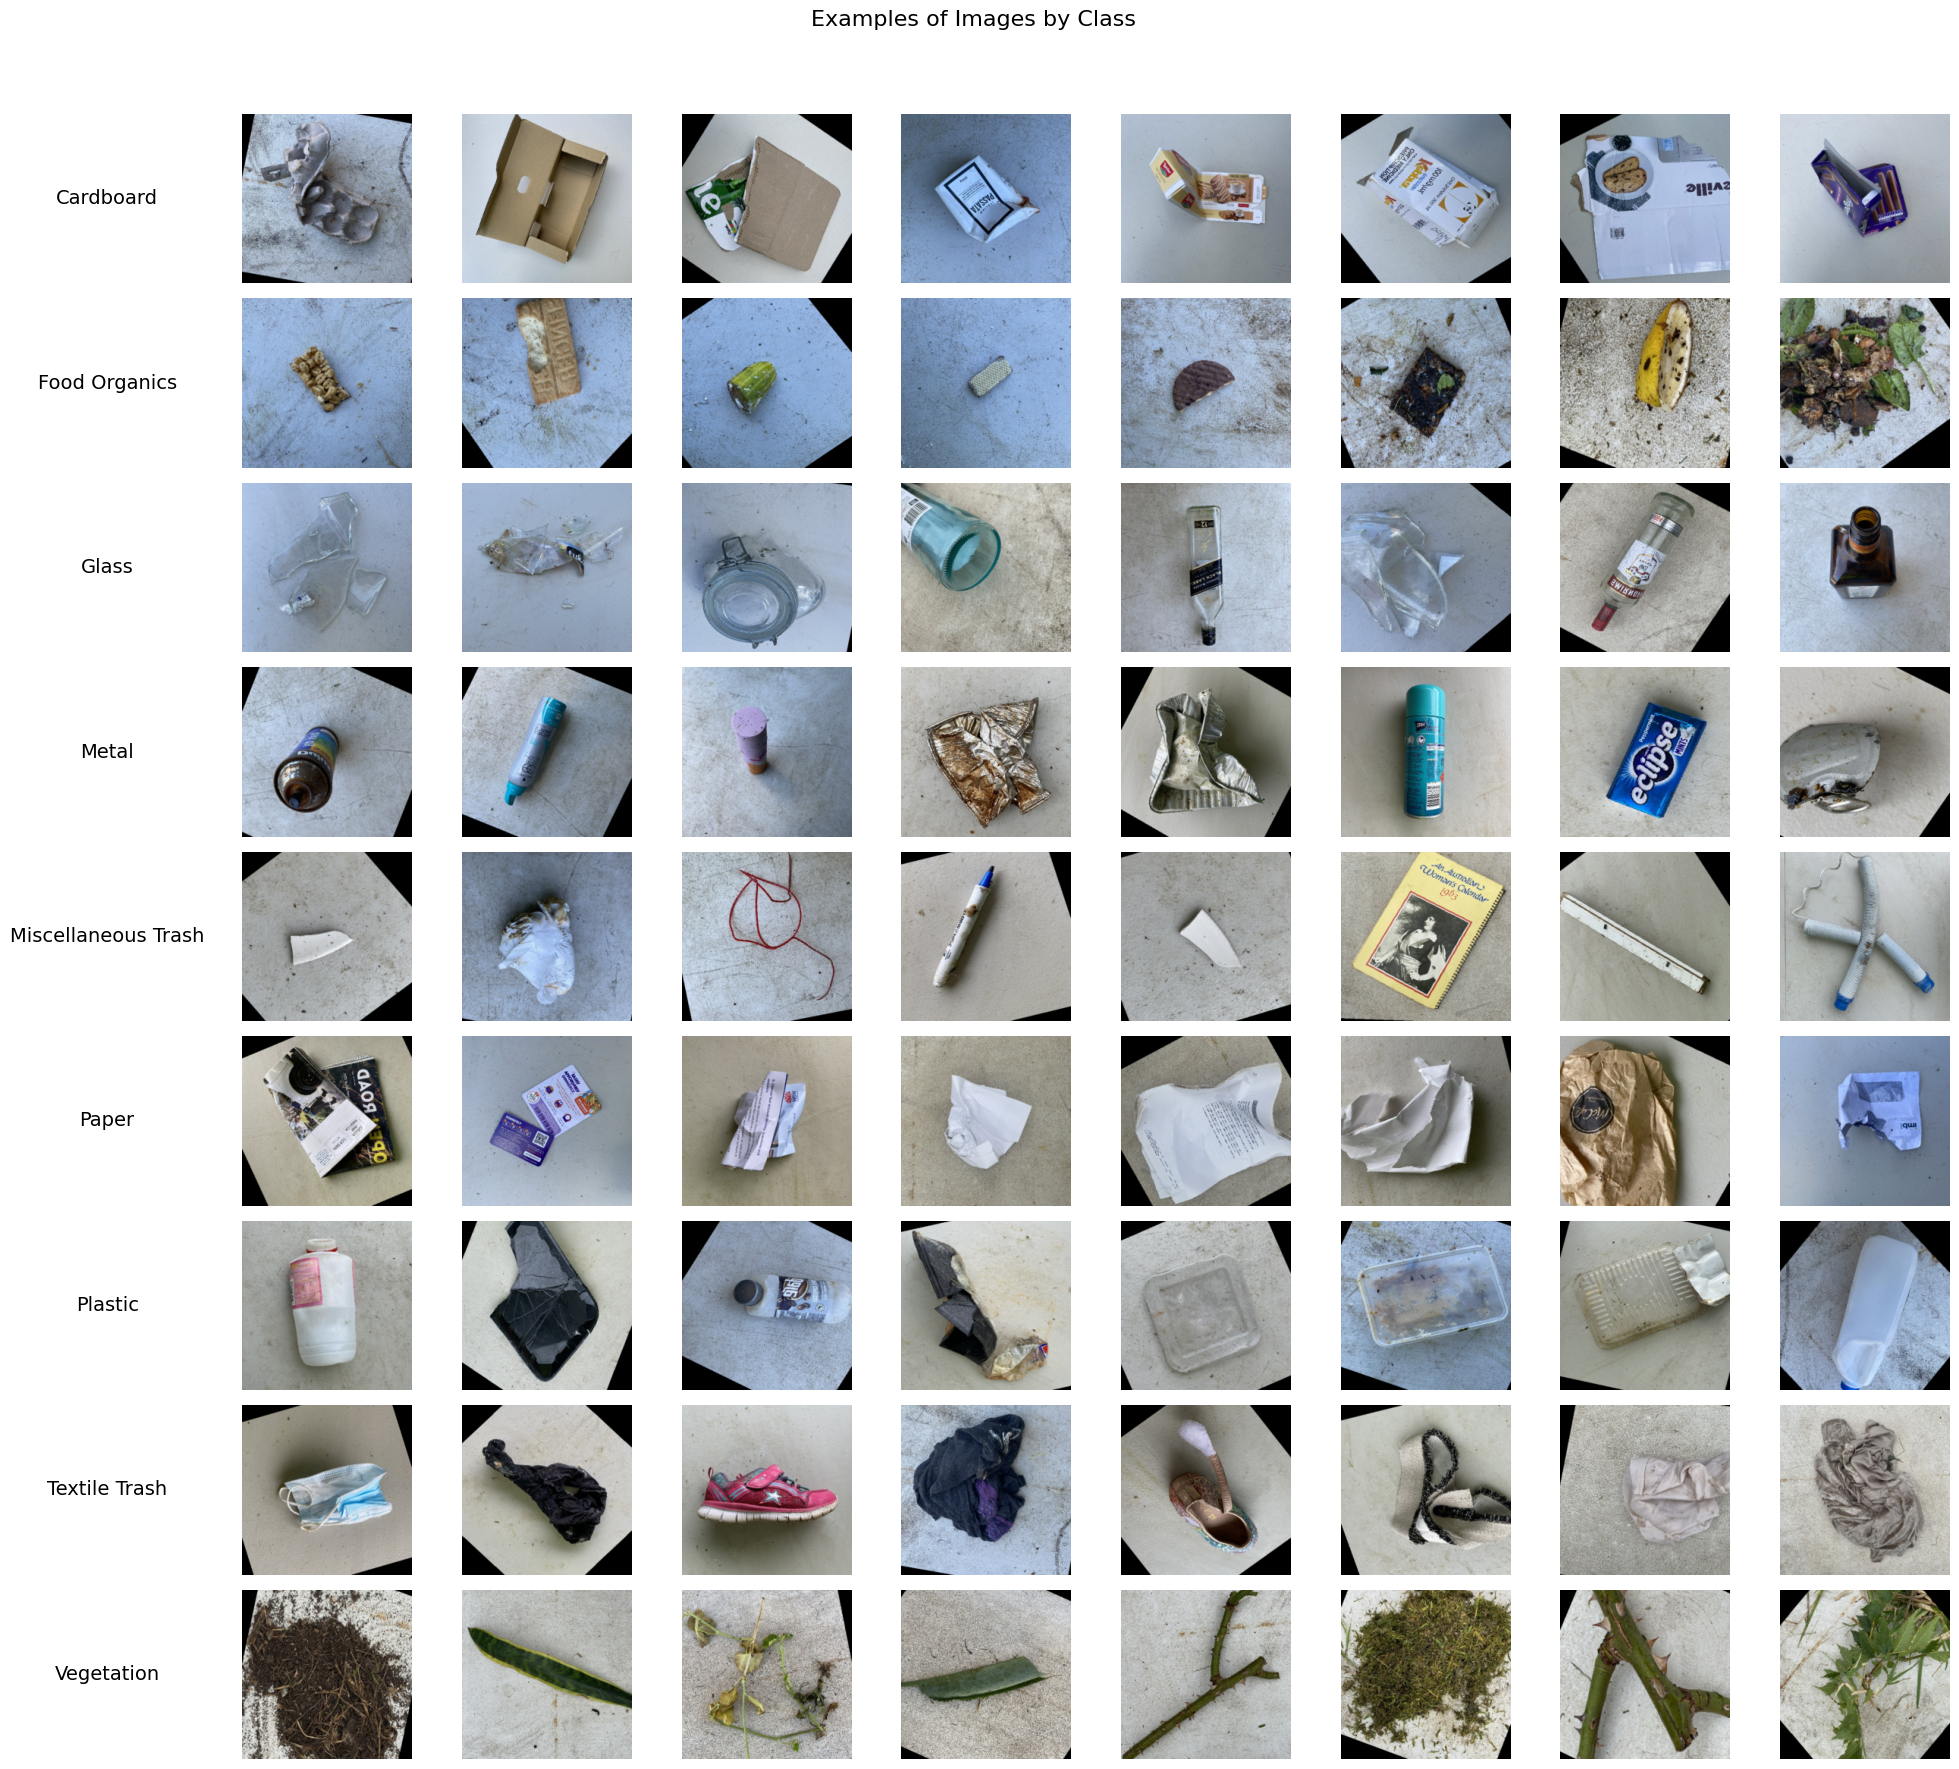

In [5]:
from collections import defaultdict

def plot_training_images_by_class(train_df_augmented, class_names, ncols=5, title="Examples of Images by Class"):
    """
    Displays examples of images organized by class (one row per class), with the class name
    at the start of each row. The column for class names is narrower.

    Args:
        train_df_augmented (pd.DataFrame): DataFrame containing augmented training data with 'image_path', 'label', and 'transformation'.
        class_names (dict): Mapping of class labels (int) to class names (str).
        ncols (int): Number of columns (images per class).
        title (str): Title of the plot.
    """
    # Group and sample images by class
    print("Sampling images by class...")
    sampled_images = defaultdict(list)

    for label in train_df_augmented['label'].unique():
        # Filter the DataFrame for the current class and sample up to `ncols` rows
        class_df = train_df_augmented[train_df_augmented['label'] == label]
        sampled_df = class_df.sample(min(len(class_df), ncols), random_state=RANDOM_SEED)
        
        for _, row in sampled_df.iterrows():
            sampled_images[label].append(row)

    # Determine the number of classes
    classes = sorted(sampled_images.keys())
    nrows = len(classes)  # One row per class

    # Configure the plot with a column for class names
    fig, axs = plt.subplots(nrows, ncols + 1, figsize=(ncols * 2.5, nrows * 2))  # +1 for class name column
    fig.suptitle(title, fontsize=16)

    for i, class_label in enumerate(classes):
        # Get the class name using the class_names dictionary
        class_name = class_names[class_label]

        # Add the class name in the first column
        axs[i, 0].text(0.5, 0.5, class_name, fontsize=14, ha="center", va="center")
        axs[i, 0].axis('off')

        # Display sampled images
        for j, row in enumerate(sampled_images[class_label]):
            img_path = row['image_path']
            transform = row['transformation']

            try:
                with Image.open(img_path).convert("RGB") as img:
                    # Apply transformation if present
                    if transform:
                        img = transform(img)
                    # Convert to NumPy array
                    if isinstance(img, torch.Tensor):
                        img = img.permute(1, 2, 0).numpy()  # Convert Tensor (C, H, W) to NumPy (H, W, C)
                        img = (img * 255).astype("uint8")  # Convert to 8-bit for visualization
                    else:
                        img = np.array(img)
                    axs[i, j + 1].imshow(img)
                    axs[i, j + 1].axis('off')
            except Exception as e:
                print(f"Error processing image {img_path}: {e}")
                axs[i, j + 1].axis('off')

    # Adjust the layout
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()
    
# Display images organized by class with class names at the beginning of each row
plot_training_images_by_class(train_df_augmented, full_dataset.classes, ncols=8, title="Examples of Images by Class")

In [6]:
# Save the DataFrames as TSV files
#train_df_augmented.to_csv('train_df_augmented.tsv', sep='\t', index=False)
#val_df.to_csv('val_df.tsv', sep='\t', index=False)
#test_df.to_csv('test_df.tsv', sep='\t', index=False)

#print("DataFrames have been saved as TSV files.")

### Dataset and DataLoader Creation

In this section, we create custom datasets and corresponding data loaders for training, validation, and testing. The `RealWasteDataset` class is used to handle the image paths, labels, and transformations.

1. **Creating Datasets**:
    - The `train_dataset`, `val_dataset`, and `test_dataset` are created using the `RealWasteDataset` class. Each dataset is initialized with:
        - `data`: A list of image file paths from the respective DataFrame.
        - `labels`: A list of labels corresponding to the images.
        - `transforms`: A list of transformations applied to the images.
        - `print_info=False`: This parameter ensures that no additional print information is shown during the dataset creation.
   <br><br>
    - The datasets are created as follows:
       - `train_dataset` uses data from `train_df_augmented`.
       - `val_dataset` uses data from `val_df`.
       - `test_dataset` uses data from `test_df`.
<br>

3. **Creating DataLoaders**:
    - DataLoaders are created for each dataset:
        - `train_loader`: For training data, with shuffling enabled (`shuffle=True`) and a batch size of `BATCH_SIZE`.
        - `val_loader`: For validation data, with shuffling disabled (`shuffle=False`) and the same batch size.
        - `test_loader`: For test data, with shuffling disabled (`shuffle=False`) and the same batch size.

These DataLoaders are then used to load the data in batches during model trining and evaluation.

In [7]:
# Load the TSV files into DataFrames
#train_df_augmented = pd.read_csv('train_df_augmented.tsv', sep='\t')
#val_df = pd.read_csv('val_df.tsv', sep='\t')
#test_df = pd.read_csv('test_df.tsv', sep='\t')

#print("DataFrames have been loaded from TSV files.")

train_dataset = RealWasteDataset(
    data=train_df_augmented['image_path'].to_list(),
    labels=train_df_augmented['label'].to_list(),
    transforms=train_df_augmented['transformation'].to_list(),
    print_info=False
)

val_dataset = RealWasteDataset(
    data=val_df['image_path'].to_list(),
    labels=val_df['label'].to_list(),
    transforms=val_df['transformation'].to_list(),
    print_info=False
)

test_dataset = RealWasteDataset(
    data=test_df['image_path'].to_list(),
    labels=test_df['label'].to_list(),
    transforms=test_df['transformation'].to_list(),
    print_info=False
)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_dataset,   batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(test_dataset,  batch_size=BATCH_SIZE, shuffle=False)

# Print dataset information
print("Train", end='\n\t')
print(f"Batches: {len(train_loader)}", end='\n\t')
print(f"Images: {len(train_loader.dataset)}")
print("Validation", end='\n\t')
print(f"Batches: {len(val_loader)}", end='\n\t')
print(f"Images: {len(val_loader.dataset)}")
print("Test", end='\n\t')
print(f"Batches: {len(test_loader)}", end='\n\t')
print(f"Images: {len(test_loader.dataset)}")

Train
	Batches: 238
	Images: 15200
Validation
	Batches: 8
	Images: 476
Test
	Batches: 8
	Images: 476


## Training Neural Networks: ResNet50, DenseNet121, MobileNetV2, VGG16, Swin Transformer Base, EfficientNetV2, Vision Transformer (ViT_L_16), and Custom CNN

This section focuses on training several powerful pretrained architectures and a custom CNN for image classification tasks:

1. **ResNet50 (Residual Networks)**:
   - Incorporates residual connections to address the vanishing gradient problem.
   - Supports deep architectures with stable training dynamics.
   - Widely used for feature extraction and image classification.
<br><br>
2. **DenseNet121 (Dense Convolutional Networks)**:
   - Connects each layer to every other layer, promoting feature reuse.
   - Requires fewer parameters while achieving competitive performance.
   - Effective for image recognition and transfer learning.
<br><br>
3. **MobileNetV2**:
   - Lightweight architecture optimized for mobile and edge devices.
   - Uses depthwise separable convolutions to reduce computational cost.
   - Ideal for applications requiring low-latency inference.
<br><br>
4. **VGG16**:
   - Deep convolutional architecture known for simplicity and effectiveness.
   - Consists of 16 layers with small 3x3 filters.
   - Performs well in transfer learning tasks with high-quality feature extraction.
<br><br>
5. **Swin Transformer Base**:
   - Hierarchical vision transformer that processes images in patches.
   - Captures both local and global context efficiently.
   - Well-suited for classification, detection, and segmentation tasks.
<br><br>
6. **EfficientNetV2**:
   - Scalable and efficient architecture that balances accuracy and computational cost.
   - Utilizes a compound scaling approach for optimal performance.
   - Excels in image classification with high accuracy and speed.
<br><br>
7. **Vision Transformer (ViT_L_16)**:
   - Uses self-attention mechanisms on image patches rather than convolutions.
   - Excels in capturing global context but requires large-scale pretraining.
   - Ideal for advanced vision tasks like segmentation and fine-grained classification.
<br><br>
8. **Custom CNN**:

   **Convolutional Block Architecture**

    Each of the 5 convolutional blocks consists of:
    - **Two convolutional layers**:
      - 3x3 kernel with same padding for local feature extraction.
    - **Batch normalization**:
      - Applied after each convolution for stable training.
    - **ReLU activations**:
      - Introduced for non-linearity.
    - **Max-pooling**:
      - 2x2 kernel with stride 2 for down-sampling.<br><br>

   **Global Average Pooling (GAP) and Fully Connected Layers**
    
    After the convolutional blocks:
    - **Global Average Pooling (GAP) layer** is applied.
    - **Fully connected layer**:
      - Contains 512 neurons with ReLU activation.
    - **Dropout layer**:
      - 30% dropout for regularization.
    - **Final fully connected layer**:
      - Outputs predictions for classification into 9 classes.

For all models, we will:
- Load pretrained weights (except for the custom CNN).
- Replace the final layer to match the dataset's number of classes.
- Fine-tune using transfer learning with Adam optimizer.
- Evaluate performance using various metrics like accuracy and F1-score.

### Model Training with Progress Bar and Metrics Plotting

This cell defines the model training process using PyTorch, including the calculation of class weights, device selection, and training with progress bars. It also includes functions to visualize training and validation metrics.

#### Key steps in the code:
1. **Class Weights Calculation:**
   - Class weights are computed to address class imbalance in the dataset. These weights are inversely proportional to the frequency of each class in the training set.
<br><br>
2. **Device Selection:**
   - The model is moved to either a GPU (if available) or the CPU, ensuring optimal performance during training.
<br><br>  
3. **`update_training_results_csv`**:
   - Updates or creates a CSV file (`training_results.csv`) to log training results.
   - Parameters:
     - `model_name`: Name of the model being trained.
     - `optimizer`: Optimizer used during training.
     - `lr`: Learning rate.
     - `weight_decay`: Weight decay value.
     - `train_losses`: List of training loss values per epoch.
     - `val_losses`: List of validation loss values per epoch.
     - `train_accuracies`: List of training accuracy values per epoch.
     - `val_accuracies`: List of validation accuracy values per epoch.
   - Removes previous entries for the same model and appends the new results.
<br><br>
4. **`train_model`**:
   - Trains a given model and evaluates it on a validation set.
   - Parameters:
     - `model`: The neural network model.
     - `train_loader`: DataLoader for the training dataset.
     - `val_loader`: DataLoader for the validation dataset.
     - `criterion`: Loss function.
     - `optimizer`: Optimizer used for training.
     - `num_epochs`: Number of training epochs (default: 10).
   - Tracks training and validation losses and accuracies for each epoch.
   - Displays progress using a `tqdm` progress bar for both training and validation.
<br><br>
5. **`plot_training_validation_metrics`**:
   - Plots training and validation losses and accuracies over epochs.
   - Parameters:
     - `train_losses`: List of training loss values.
     - `val_losses`: List of validation loss values.
     - `train_accuracies`: List of training accuracy percentages.
     - `val_accuracies`: List of validation accuracy percentages.
   - Creates two subplots:
     - Loss per epoch.
     - Accuracy per epoch.
   - Displays the graphs for visualization of model performance.

In [8]:
import torch
import torch.optim as optim
import torch.nn as nn
from torchvision import models, transforms
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
import matplotlib.pyplot as plt
from tqdm import tqdm

# Create the class weights
class_counts = np.bincount(train_dataset.labels)
class_weights = 1.0 / class_counts
class_weights = class_weights / class_weights.sum() * len(class_counts)
num_classes = len(full_dataset.classes)

# Get the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Update the training results dataframe
def update_training_results_csv(model_name, optimizer, lr, weight_decay, train_losses, val_losses, train_accuracies, val_accuracies):

    csv_path = 'training_results.csv'
    
    # Check if the CSV file exists
    if os.path.exists(csv_path):
        df = pd.read_csv(csv_path)
    else:
        # If it doesn't exist, create an empty DataFrame with the necessary columns
        df = pd.DataFrame(columns=["model_name", 
                                   "epoch",
                                   "optimizer",
                                   "learning_rate",
                                   "weight_decay",
                                   "train_loss", 
                                   "val_loss", 
                                   "train_accuracy", 
                                   "val_accuracy"
                                  ]
                         )
    
    # Remove any old entries for the model
    df = df[df['model_name'] != model_name]
    
    # Create a new DataFrame with the current results
    new_entries = {
        "model_name": [model_name] * len(train_losses),
        "epoch": list(range(1, len(train_losses) + 1)),
        "optimizer": [optimizer] * len(train_losses),
        "learning_rate": [lr] * len(train_losses),
        "weight_decay": [weight_decay] * len(train_losses),
        "train_loss": train_losses,
        "val_loss": val_losses,
        "train_accuracy": train_accuracies,
        "val_accuracy": val_accuracies
    }
    
    new_df = pd.DataFrame(new_entries)
    
    # Concatenate the new data with the existing ones
    df = pd.concat([df, new_df], ignore_index=True)
    
    # Save the updated DataFrame to the CSV file
    df.to_csv(csv_path, index=False)
    
    print(f"Training data for '{model_name}' updated in '{csv_path}'")

# Function to train the model with a progress bar
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        # Progress bar for training
        with tqdm(train_loader, desc=f"Training Epoch {epoch+1}/{num_epochs}", unit="batch") as tepoch:
            for images, labels in tepoch:
                images, labels = images.to(device), labels.to(device)

                # Zero the gradients
                optimizer.zero_grad()

                # Forward pass through the model
                outputs = model(images)
                loss = criterion(outputs, labels)

                # Backpropagation
                loss.backward()
                optimizer.step()

                running_loss += loss.item()

                # Calculate accuracy
                _, predicted = torch.max(outputs, 1)
                total_train += labels.size(0)
                correct_train += (predicted == labels).sum().item()

                # Update the progress bar
                tepoch.set_postfix(loss=running_loss / len(tepoch), accuracy=100 * correct_train / total_train)

        train_losses.append(running_loss / len(train_loader))
        train_accuracies.append(100 * correct_train / total_train)

        # Validation
        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0

        # Progress bar for validation
        with tqdm(val_loader, desc=f"Validation Epoch {epoch+1}/{num_epochs}", unit="batch") as vepoch:
            with torch.no_grad():
                for images, labels in vepoch:
                    images, labels = images.to(device), labels.to(device)
                    outputs = model(images)
                    loss = criterion(outputs, labels)

                    val_loss += loss.item()

                    # Calculate accuracy
                    _, predicted = torch.max(outputs, 1)
                    total_val += labels.size(0)
                    correct_val += (predicted == labels).sum().item()

                    # Update the progress bar
                    vepoch.set_postfix(loss=val_loss / len(vepoch), accuracy=100 * correct_val / total_val)

        val_losses.append(val_loss / len(val_loader))
        val_accuracies.append(100 * correct_val / total_val)

        print(f"Epoch {epoch+1}/{num_epochs}, "
              f"Train Loss: {train_losses[-1]:.4f}, Train Accuracy: {train_accuracies[-1]:.2f}%, "
              f"Val Loss: {val_losses[-1]:.4f}, Val Accuracy: {val_accuracies[-1]:.2f}%")

    return train_losses, val_losses, train_accuracies, val_accuracies

# Useful plot function
def plot_training_validation_metrics(train_losses, val_losses, train_accuracies, val_accuracies):
    """
    Function to plot the graph of losses and accuracies during training and validation.

    Args:
        train_losses (list): List containing loss values during training.
        val_losses (list): List containing loss values during validation.
        train_accuracies (list): List containing accuracies during training.
        val_accuracies (list): List containing accuracies during validation.
    """
    plt.figure(figsize=(12, 6))

    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Loss per Epoch')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.title('Accuracy per Epoch')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    plt.tight_layout()
    plt.show()

### ResNet50

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 188MB/s]
Validation Epoch 1/15: 100%|██████████| 8/8 [00:03<00:00,  2.04batch/s, accuracy=62.6, loss=1.4]  


Epoch 1/15, Train Loss: 1.9398, Train Accuracy: 38.05%, Val Loss: 1.4049, Val Accuracy: 62.61%


Validation Epoch 2/15: 100%|██████████| 8/8 [00:03<00:00,  2.06batch/s, accuracy=77.1, loss=0.652] 


Epoch 2/15, Train Loss: 0.9707, Train Accuracy: 74.74%, Val Loss: 0.6519, Val Accuracy: 77.10%


Validation Epoch 3/15: 100%|██████████| 8/8 [00:03<00:00,  2.02batch/s, accuracy=85.1, loss=0.395] 


Epoch 3/15, Train Loss: 0.4812, Train Accuracy: 85.33%, Val Loss: 0.3950, Val Accuracy: 85.08%


Validation Epoch 4/15: 100%|██████████| 8/8 [00:04<00:00,  1.99batch/s, accuracy=89.5, loss=0.296] 


Epoch 4/15, Train Loss: 0.2954, Train Accuracy: 90.24%, Val Loss: 0.2955, Val Accuracy: 89.50%


Validation Epoch 5/15: 100%|██████████| 8/8 [00:04<00:00,  1.88batch/s, accuracy=92, loss=0.226]   


Epoch 5/15, Train Loss: 0.1945, Train Accuracy: 93.95%, Val Loss: 0.2261, Val Accuracy: 92.02%


Validation Epoch 6/15: 100%|██████████| 8/8 [00:05<00:00,  1.52batch/s, accuracy=93.7, loss=0.203] 


Epoch 6/15, Train Loss: 0.1324, Train Accuracy: 95.84%, Val Loss: 0.2030, Val Accuracy: 93.70%


Validation Epoch 7/15: 100%|██████████| 8/8 [00:04<00:00,  1.88batch/s, accuracy=94.1, loss=0.175] 


Epoch 7/15, Train Loss: 0.0906, Train Accuracy: 97.48%, Val Loss: 0.1749, Val Accuracy: 94.12%


Validation Epoch 8/15: 100%|██████████| 8/8 [00:04<00:00,  1.96batch/s, accuracy=94.1, loss=0.188] 


Epoch 8/15, Train Loss: 0.0721, Train Accuracy: 98.11%, Val Loss: 0.1884, Val Accuracy: 94.12%


Validation Epoch 9/15: 100%|██████████| 8/8 [00:04<00:00,  1.97batch/s, accuracy=93.9, loss=0.185] 


Epoch 9/15, Train Loss: 0.0524, Train Accuracy: 98.82%, Val Loss: 0.1850, Val Accuracy: 93.91%


Validation Epoch 10/15: 100%|██████████| 8/8 [00:03<00:00,  2.04batch/s, accuracy=94.7, loss=0.171] 


Epoch 10/15, Train Loss: 0.0386, Train Accuracy: 99.14%, Val Loss: 0.1713, Val Accuracy: 94.75%


Validation Epoch 11/15: 100%|██████████| 8/8 [00:04<00:00,  1.97batch/s, accuracy=93.9, loss=0.186] 


Epoch 11/15, Train Loss: 0.0312, Train Accuracy: 99.24%, Val Loss: 0.1857, Val Accuracy: 93.91%


Validation Epoch 12/15: 100%|██████████| 8/8 [00:04<00:00,  1.99batch/s, accuracy=94.3, loss=0.171] 


Epoch 12/15, Train Loss: 0.0271, Train Accuracy: 99.38%, Val Loss: 0.1708, Val Accuracy: 94.33%


Validation Epoch 13/15: 100%|██████████| 8/8 [00:05<00:00,  1.56batch/s, accuracy=94.7, loss=0.18]  


Epoch 13/15, Train Loss: 0.0225, Train Accuracy: 99.53%, Val Loss: 0.1802, Val Accuracy: 94.75%


Validation Epoch 14/15: 100%|██████████| 8/8 [00:03<00:00,  2.05batch/s, accuracy=93.1, loss=0.205] 


Epoch 14/15, Train Loss: 0.0217, Train Accuracy: 99.54%, Val Loss: 0.2047, Val Accuracy: 93.07%


Validation Epoch 15/15: 100%|██████████| 8/8 [00:04<00:00,  1.71batch/s, accuracy=93.5, loss=0.199] 


Epoch 15/15, Train Loss: 0.0206, Train Accuracy: 99.49%, Val Loss: 0.1990, Val Accuracy: 93.49%
Model saved to /kaggle/working/trained_ResNet50_model.pth
Dati di training per 'ResNet50' aggiornati in 'training_results.tsv'


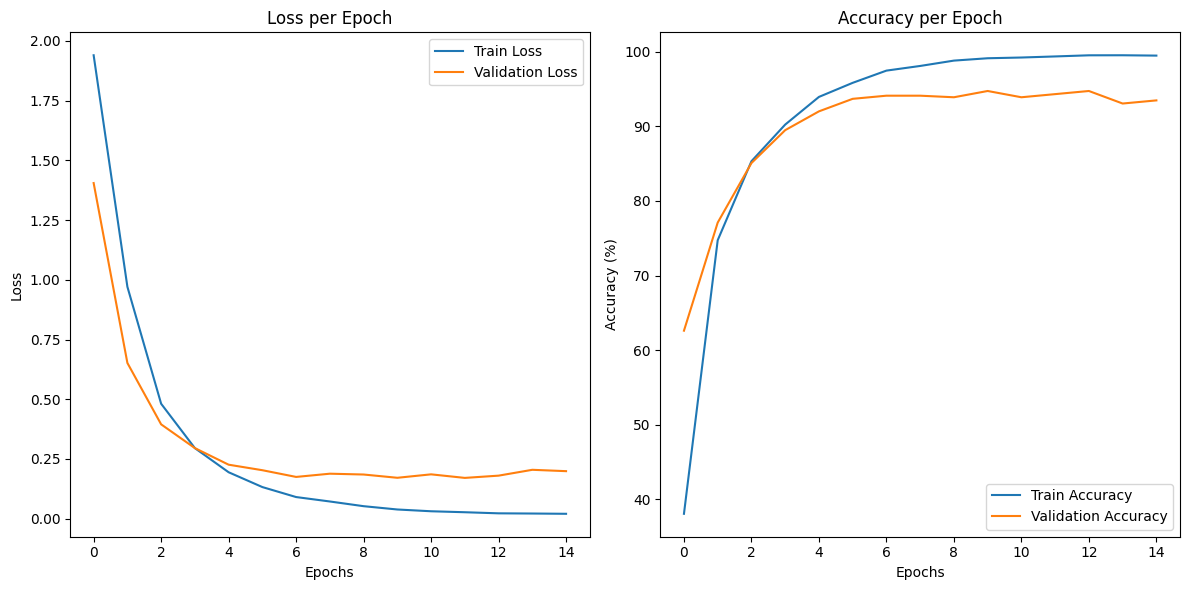

In [9]:
from torchvision.models import ResNet50_Weights

# Load the model
model_name = "ResNet50"
model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
model.fc = nn.Linear(model.fc.in_features, num_classes)

# Number of epochs
num_epochs = 15

for param in model.fc.parameters():
    param.requires_grad = True

# Move the model to GPU, if available
model = model.to(device)

# Loss function and optimizer
weights = torch.tensor(class_weights.copy(), dtype=torch.float32).to(device)  # Customize the weights
criterion = nn.CrossEntropyLoss(weight=weights)
learning_rate = 1e-5
weight_decay = 1e-2
optimizer = optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()), 
    lr=learning_rate, 
    weight_decay=weight_decay
)

# Start training
train_losses, val_losses, train_accuracies, val_accuracies = train_model(
    model, train_loader, val_loader, criterion, optimizer, num_epochs=num_epochs
)

# Save the model
model_save_path = f"/kaggle/working/trained_{model_name}_model.pth"
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

# Update metrics dataset
update_training_results_csv(model_name, "adam", learning_rate, weight_decay, train_losses, val_losses, train_accuracies, val_accuracies)

# Plot the metrics
plot_training_validation_metrics(train_losses, val_losses, train_accuracies, val_accuracies)

### DenseNet121

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 67.4MB/s]
Validation Epoch 1/15: 100%|██████████| 8/8 [00:04<00:00,  1.69batch/s, accuracy=69.5, loss=1.02] 


Epoch 1/15, Train Loss: 1.5556, Train Accuracy: 49.46%, Val Loss: 1.0163, Val Accuracy: 69.54%


Validation Epoch 2/15: 100%|██████████| 8/8 [00:04<00:00,  1.92batch/s, accuracy=78.8, loss=0.617] 


Epoch 2/15, Train Loss: 0.8062, Train Accuracy: 76.73%, Val Loss: 0.6174, Val Accuracy: 78.78%


Validation Epoch 3/15: 100%|██████████| 8/8 [00:04<00:00,  2.00batch/s, accuracy=84.9, loss=0.438]


Epoch 3/15, Train Loss: 0.5338, Train Accuracy: 84.42%, Val Loss: 0.4384, Val Accuracy: 84.87%


Validation Epoch 4/15: 100%|██████████| 8/8 [00:03<00:00,  2.10batch/s, accuracy=87.4, loss=0.343] 


Epoch 4/15, Train Loss: 0.3796, Train Accuracy: 89.11%, Val Loss: 0.3435, Val Accuracy: 87.39%


Validation Epoch 5/15: 100%|██████████| 8/8 [00:04<00:00,  1.98batch/s, accuracy=91, loss=0.29]    


Epoch 5/15, Train Loss: 0.2830, Train Accuracy: 92.10%, Val Loss: 0.2896, Val Accuracy: 90.97%


Validation Epoch 6/15: 100%|██████████| 8/8 [00:04<00:00,  1.97batch/s, accuracy=92.2, loss=0.247] 


Epoch 6/15, Train Loss: 0.2100, Train Accuracy: 94.06%, Val Loss: 0.2468, Val Accuracy: 92.23%


Validation Epoch 7/15: 100%|██████████| 8/8 [00:04<00:00,  1.98batch/s, accuracy=92, loss=0.229]   


Epoch 7/15, Train Loss: 0.1631, Train Accuracy: 95.87%, Val Loss: 0.2290, Val Accuracy: 92.02%


Validation Epoch 8/15: 100%|██████████| 8/8 [00:04<00:00,  1.91batch/s, accuracy=93.3, loss=0.21]  


Epoch 8/15, Train Loss: 0.1267, Train Accuracy: 96.84%, Val Loss: 0.2100, Val Accuracy: 93.28%


Validation Epoch 9/15: 100%|██████████| 8/8 [00:03<00:00,  2.02batch/s, accuracy=93.7, loss=0.19]  


Epoch 9/15, Train Loss: 0.0991, Train Accuracy: 97.59%, Val Loss: 0.1898, Val Accuracy: 93.70%


Validation Epoch 10/15: 100%|██████████| 8/8 [00:04<00:00,  1.97batch/s, accuracy=92.9, loss=0.191] 


Epoch 10/15, Train Loss: 0.0785, Train Accuracy: 98.26%, Val Loss: 0.1913, Val Accuracy: 92.86%


Validation Epoch 11/15: 100%|██████████| 8/8 [00:03<00:00,  2.02batch/s, accuracy=94.5, loss=0.206] 


Epoch 11/15, Train Loss: 0.0641, Train Accuracy: 98.68%, Val Loss: 0.2059, Val Accuracy: 94.54%


Validation Epoch 12/15: 100%|██████████| 8/8 [00:03<00:00,  2.01batch/s, accuracy=93.5, loss=0.197] 


Epoch 12/15, Train Loss: 0.0499, Train Accuracy: 99.11%, Val Loss: 0.1966, Val Accuracy: 93.49%


Validation Epoch 13/15: 100%|██████████| 8/8 [00:03<00:00,  2.06batch/s, accuracy=93.5, loss=0.183] 


Epoch 13/15, Train Loss: 0.0462, Train Accuracy: 99.03%, Val Loss: 0.1832, Val Accuracy: 93.49%


Validation Epoch 14/15: 100%|██████████| 8/8 [00:04<00:00,  1.98batch/s, accuracy=93.1, loss=0.213] 


Epoch 14/15, Train Loss: 0.0400, Train Accuracy: 99.30%, Val Loss: 0.2127, Val Accuracy: 93.07%


Validation Epoch 15/15: 100%|██████████| 8/8 [00:04<00:00,  1.98batch/s, accuracy=94.1, loss=0.176] 


Epoch 15/15, Train Loss: 0.0358, Train Accuracy: 99.22%, Val Loss: 0.1760, Val Accuracy: 94.12%
Model saved to /kaggle/working/trained_DenseNet121_model.pth
Dati di training per 'DenseNet121' aggiornati in 'training_results.tsv'


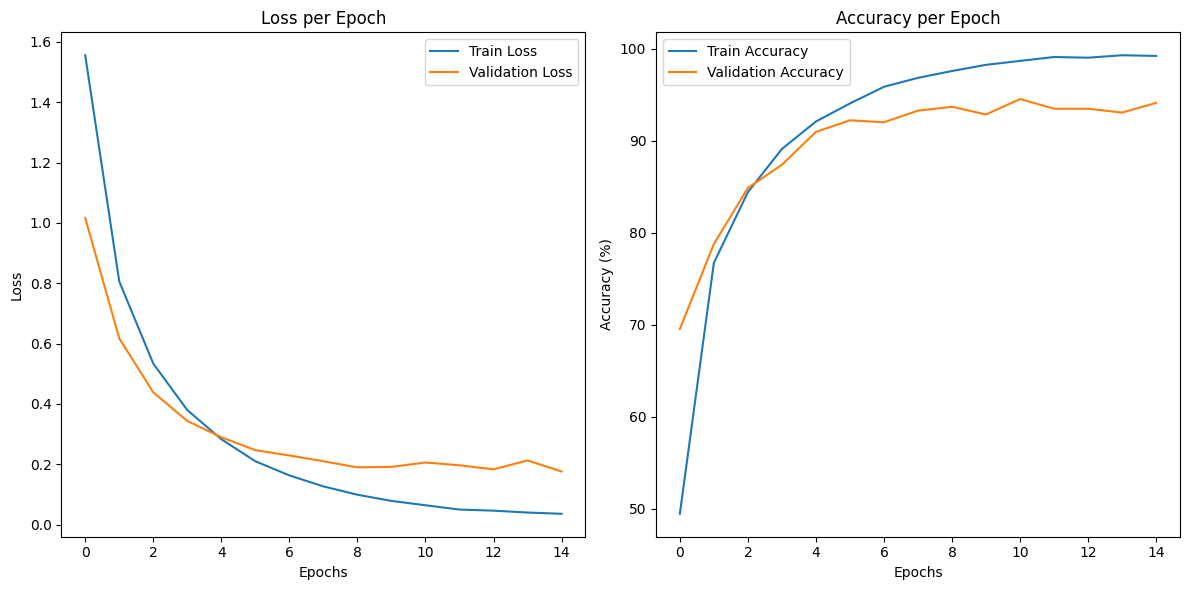

In [9]:
from torchvision.models import DenseNet121_Weights

# Load the model
model_name = "DenseNet121"
model = models.densenet121(weights=models.DenseNet121_Weights.DEFAULT)
model.classifier = nn.Linear(model.classifier.in_features, num_classes)

# Number of epochs
num_epochs = 15

for param in model.classifier.parameters():
    param.requires_grad = True

# Move the model to GPU, if available
model = model.to(device)

# Loss function and optimizer
weights = torch.tensor(class_weights.copy(), dtype=torch.float32).to(device)  # Customize the weights
criterion = nn.CrossEntropyLoss(weight=weights)
learning_rate = 1e-5
weight_decay = 1e-2
optimizer = optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()), 
    lr=learning_rate, 
    weight_decay=weight_decay
)

# Start training
train_losses, val_losses, train_accuracies, val_accuracies = train_model(
    model, train_loader, val_loader, criterion, optimizer, num_epochs=num_epochs
)

# Save the model
model_save_path = f"/kaggle/working/trained_{model_name}_model.pth"
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

# Update metrics dataset
update_training_results_csv(model_name, "adam", learning_rate, weight_decay, train_losses, val_losses, train_accuracies, val_accuracies)

# Plot the metrics
plot_training_validation_metrics(train_losses, val_losses, train_accuracies, val_accuracies)

### MobileNetV2

Downloading: "https://download.pytorch.org/models/mobilenet_v2-7ebf99e0.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-7ebf99e0.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 101MB/s] 
Validation Epoch 1/15: 100%|██████████| 8/8 [00:03<00:00,  2.07batch/s, accuracy=75.2, loss=0.658] 


Epoch 1/15, Train Loss: 1.2905, Train Accuracy: 61.02%, Val Loss: 0.6583, Val Accuracy: 75.21%


Validation Epoch 2/15: 100%|██████████| 8/8 [00:03<00:00,  2.19batch/s, accuracy=87.2, loss=0.349] 


Epoch 2/15, Train Loss: 0.4669, Train Accuracy: 84.14%, Val Loss: 0.3492, Val Accuracy: 87.18%


Validation Epoch 3/15: 100%|██████████| 8/8 [00:03<00:00,  2.39batch/s, accuracy=91, loss=0.255]   


Epoch 3/15, Train Loss: 0.2692, Train Accuracy: 91.01%, Val Loss: 0.2552, Val Accuracy: 90.97%


Validation Epoch 4/15: 100%|██████████| 8/8 [00:03<00:00,  2.33batch/s, accuracy=92.4, loss=0.217] 


Epoch 4/15, Train Loss: 0.1659, Train Accuracy: 94.55%, Val Loss: 0.2166, Val Accuracy: 92.44%


Validation Epoch 5/15: 100%|██████████| 8/8 [00:03<00:00,  2.27batch/s, accuracy=93.3, loss=0.204] 


Epoch 5/15, Train Loss: 0.1123, Train Accuracy: 96.17%, Val Loss: 0.2042, Val Accuracy: 93.28%


Validation Epoch 6/15: 100%|██████████| 8/8 [00:03<00:00,  2.28batch/s, accuracy=93.9, loss=0.2]   


Epoch 6/15, Train Loss: 0.0748, Train Accuracy: 97.69%, Val Loss: 0.2003, Val Accuracy: 93.91%


Validation Epoch 7/15: 100%|██████████| 8/8 [00:03<00:00,  2.28batch/s, accuracy=94.5, loss=0.19]  


Epoch 7/15, Train Loss: 0.0551, Train Accuracy: 98.30%, Val Loss: 0.1899, Val Accuracy: 94.54%


Validation Epoch 8/15: 100%|██████████| 8/8 [00:03<00:00,  2.29batch/s, accuracy=94.3, loss=0.157] 


Epoch 8/15, Train Loss: 0.0439, Train Accuracy: 98.78%, Val Loss: 0.1572, Val Accuracy: 94.33%


Validation Epoch 9/15: 100%|██████████| 8/8 [00:03<00:00,  2.32batch/s, accuracy=94.5, loss=0.175] 


Epoch 9/15, Train Loss: 0.0340, Train Accuracy: 98.93%, Val Loss: 0.1748, Val Accuracy: 94.54%


Validation Epoch 10/15: 100%|██████████| 8/8 [00:03<00:00,  2.07batch/s, accuracy=95.6, loss=0.165] 


Epoch 10/15, Train Loss: 0.0250, Train Accuracy: 99.30%, Val Loss: 0.1654, Val Accuracy: 95.59%


Validation Epoch 11/15: 100%|██████████| 8/8 [00:03<00:00,  2.20batch/s, accuracy=95.4, loss=0.186] 


Epoch 11/15, Train Loss: 0.0226, Train Accuracy: 99.34%, Val Loss: 0.1860, Val Accuracy: 95.38%


Validation Epoch 12/15: 100%|██████████| 8/8 [00:03<00:00,  2.33batch/s, accuracy=94.5, loss=0.186] 


Epoch 12/15, Train Loss: 0.0232, Train Accuracy: 99.27%, Val Loss: 0.1863, Val Accuracy: 94.54%


Validation Epoch 13/15: 100%|██████████| 8/8 [00:03<00:00,  2.32batch/s, accuracy=95, loss=0.16]    


Epoch 13/15, Train Loss: 0.0191, Train Accuracy: 99.47%, Val Loss: 0.1603, Val Accuracy: 94.96%


Validation Epoch 14/15: 100%|██████████| 8/8 [00:03<00:00,  2.05batch/s, accuracy=95.8, loss=0.151] 


Epoch 14/15, Train Loss: 0.0145, Train Accuracy: 99.61%, Val Loss: 0.1509, Val Accuracy: 95.80%


Validation Epoch 15/15: 100%|██████████| 8/8 [00:03<00:00,  2.31batch/s, accuracy=95.6, loss=0.159] 


Epoch 15/15, Train Loss: 0.0158, Train Accuracy: 99.60%, Val Loss: 0.1591, Val Accuracy: 95.59%
Model saved to /kaggle/working/trained_MobileNetV2_model.pth
Dati di training per 'MobileNetV2' aggiornati in 'training_results.tsv'


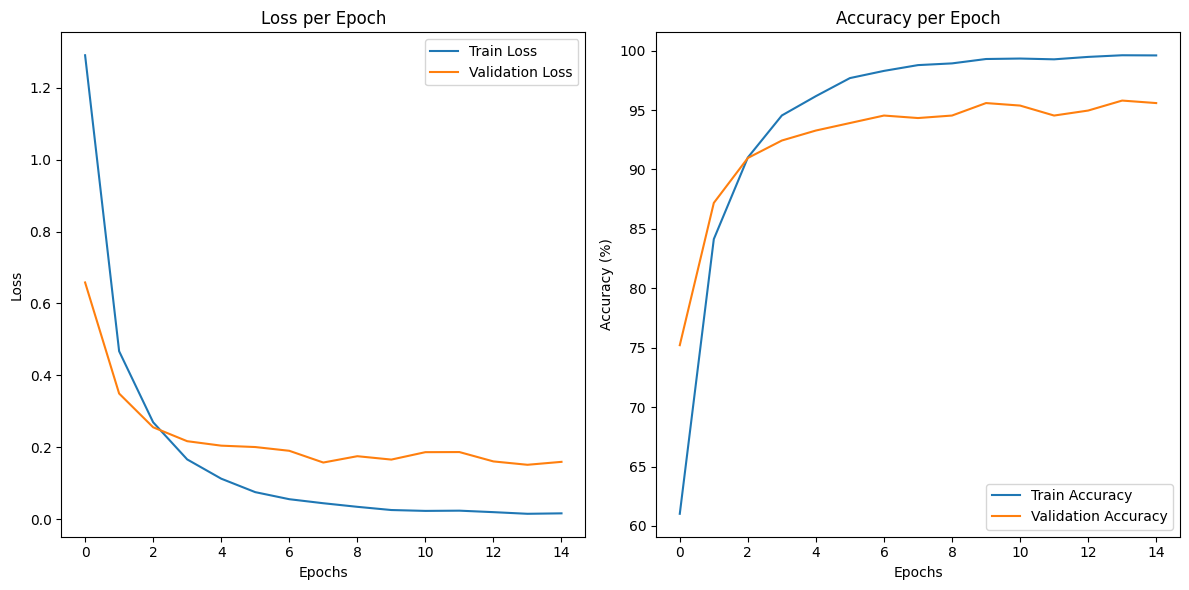

In [10]:
from torchvision.models import MobileNet_V2_Weights

# Load the model
model_name = "MobileNetV2"
model = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.DEFAULT)
model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)

# Number of epochs
num_epochs = 15

for param in model.classifier.parameters():
    param.requires_grad = True
    
# Move the model to GPU, if available
model = model.to(device)

# Loss function and optimizer
weights = torch.tensor(class_weights.copy(), dtype=torch.float32).to(device)  # Customize the weights
criterion = nn.CrossEntropyLoss(weight=weights)
learning_rate = 5e-5
weight_decay = 1e-3
optimizer = optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()), 
    lr=learning_rate, 
    weight_decay=weight_decay
)

# Start training
train_losses, val_losses, train_accuracies, val_accuracies = train_model(
    model, train_loader, val_loader, criterion, optimizer, num_epochs=num_epochs
)

# Save the model
model_save_path = f"/kaggle/working/trained_{model_name.replace(' ', '_')}_model.pth"
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

# Update metrics dataset
update_training_results_csv(model_name, "adam", learning_rate, weight_decay, train_losses, val_losses, train_accuracies, val_accuracies)

# Plot the metrics
plot_training_validation_metrics(train_losses, val_losses, train_accuracies, val_accuracies)

### VGG-16

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 228MB/s] 
Validation Epoch 1/15: 100%|██████████| 8/8 [00:04<00:00,  1.77batch/s, accuracy=76.7, loss=0.609] 


Epoch 1/15, Train Loss: 1.1947, Train Accuracy: 54.38%, Val Loss: 0.6088, Val Accuracy: 76.68%


Validation Epoch 2/15: 100%|██████████| 8/8 [00:04<00:00,  1.90batch/s, accuracy=83.4, loss=0.431] 


Epoch 2/15, Train Loss: 0.5504, Train Accuracy: 78.99%, Val Loss: 0.4308, Val Accuracy: 83.40%


Validation Epoch 3/15: 100%|██████████| 8/8 [00:04<00:00,  1.80batch/s, accuracy=86.1, loss=0.358]


Epoch 3/15, Train Loss: 0.3728, Train Accuracy: 85.50%, Val Loss: 0.3576, Val Accuracy: 86.13%


Validation Epoch 4/15: 100%|██████████| 8/8 [00:04<00:00,  1.86batch/s, accuracy=87.6, loss=0.314] 


Epoch 4/15, Train Loss: 0.2717, Train Accuracy: 89.06%, Val Loss: 0.3139, Val Accuracy: 87.61%


Validation Epoch 5/15: 100%|██████████| 8/8 [00:04<00:00,  1.79batch/s, accuracy=89.9, loss=0.329] 


Epoch 5/15, Train Loss: 0.2016, Train Accuracy: 91.74%, Val Loss: 0.3285, Val Accuracy: 89.92%


Validation Epoch 6/15: 100%|██████████| 8/8 [00:04<00:00,  1.85batch/s, accuracy=91, loss=0.286]   


Epoch 6/15, Train Loss: 0.1616, Train Accuracy: 93.22%, Val Loss: 0.2859, Val Accuracy: 90.97%


Validation Epoch 7/15: 100%|██████████| 8/8 [00:04<00:00,  1.75batch/s, accuracy=91.2, loss=0.267] 


Epoch 7/15, Train Loss: 0.1350, Train Accuracy: 94.39%, Val Loss: 0.2669, Val Accuracy: 91.18%


Validation Epoch 8/15: 100%|██████████| 8/8 [00:04<00:00,  1.79batch/s, accuracy=92.6, loss=0.258] 


Epoch 8/15, Train Loss: 0.1036, Train Accuracy: 95.74%, Val Loss: 0.2575, Val Accuracy: 92.65%


Validation Epoch 9/15: 100%|██████████| 8/8 [00:04<00:00,  1.74batch/s, accuracy=91.6, loss=0.256] 


Epoch 9/15, Train Loss: 0.0991, Train Accuracy: 96.05%, Val Loss: 0.2561, Val Accuracy: 91.60%


Validation Epoch 10/15: 100%|██████████| 8/8 [00:04<00:00,  1.88batch/s, accuracy=92.6, loss=0.26]  


Epoch 10/15, Train Loss: 0.0900, Train Accuracy: 96.36%, Val Loss: 0.2596, Val Accuracy: 92.65%


Validation Epoch 11/15: 100%|██████████| 8/8 [00:04<00:00,  1.89batch/s, accuracy=89.7, loss=0.325] 


Epoch 11/15, Train Loss: 0.0703, Train Accuracy: 97.21%, Val Loss: 0.3251, Val Accuracy: 89.71%


Validation Epoch 12/15: 100%|██████████| 8/8 [00:04<00:00,  1.80batch/s, accuracy=91.8, loss=0.283] 


Epoch 12/15, Train Loss: 0.0679, Train Accuracy: 97.36%, Val Loss: 0.2827, Val Accuracy: 91.81%


Validation Epoch 13/15: 100%|██████████| 8/8 [00:04<00:00,  1.84batch/s, accuracy=89.9, loss=0.351] 


Epoch 13/15, Train Loss: 0.0670, Train Accuracy: 97.40%, Val Loss: 0.3513, Val Accuracy: 89.92%


Validation Epoch 14/15: 100%|██████████| 8/8 [00:04<00:00,  1.75batch/s, accuracy=90.3, loss=0.291] 


Epoch 14/15, Train Loss: 0.0599, Train Accuracy: 97.62%, Val Loss: 0.2914, Val Accuracy: 90.34%


Validation Epoch 15/15: 100%|██████████| 8/8 [00:04<00:00,  1.80batch/s, accuracy=92.9, loss=0.259] 


Epoch 15/15, Train Loss: 0.0596, Train Accuracy: 97.70%, Val Loss: 0.2588, Val Accuracy: 92.86%
Model saved to /kaggle/working/trained_VGG-16_model.pth
Dati di training per 'VGG-16' aggiornati in 'training_results.tsv'


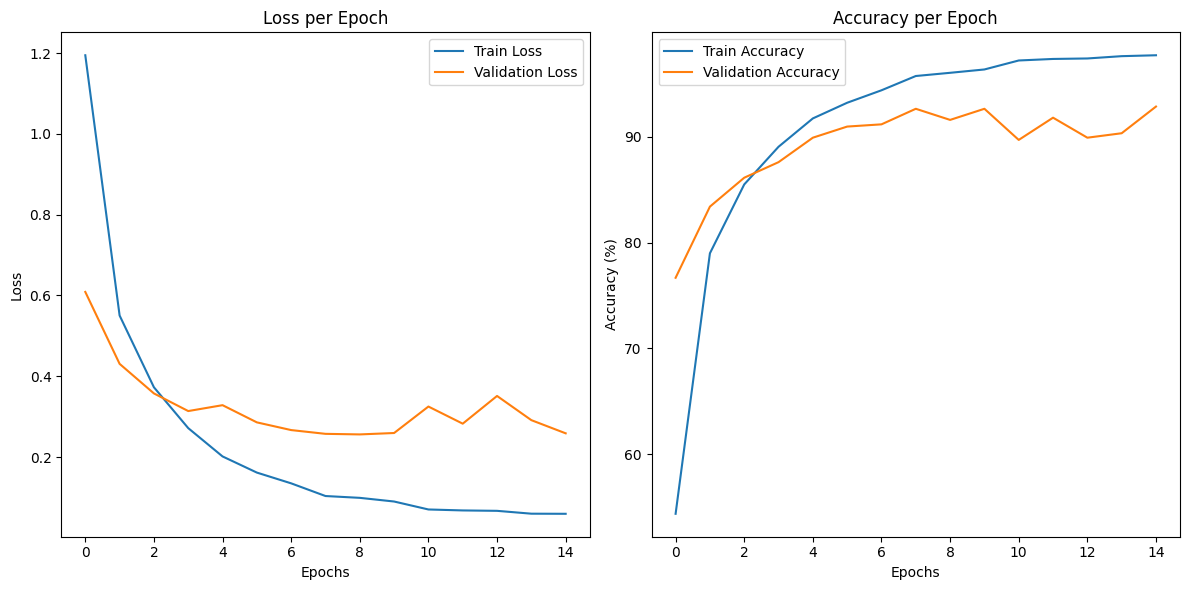

In [11]:
from torchvision.models import VGG16_Weights

# Load the model
model_name = "VGG-16"
model = models.vgg16(weights=models.VGG16_Weights.DEFAULT)
model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)

# Number of epochs
num_epochs = 15

for param in model.classifier.parameters():
    param.requires_grad = True

# Move the model to GPU, if available
model = model.to(device)

# Loss function and optimizer
weights = torch.tensor(class_weights.copy(), dtype=torch.float32).to(device)  # Customize the weights
criterion = nn.CrossEntropyLoss(weight=weights)
learning_rate = 1e-5
weight_decay = 1e-2
optimizer = optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()), 
    lr=learning_rate, 
    weight_decay=weight_decay
)
# Start training
train_losses, val_losses, train_accuracies, val_accuracies = train_model(
    model, train_loader, val_loader, criterion, optimizer, num_epochs=num_epochs
)

# Save the model
model_save_path = f"/kaggle/working/trained_{model_name.replace(' ', '_')}_model.pth"
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

# Update metrics dataset
update_training_results_csv(model_name, "adam", learning_rate, weight_decay, train_losses, val_losses, train_accuracies, val_accuracies)

# Plot the metrics
plot_training_validation_metrics(train_losses, val_losses, train_accuracies, val_accuracies)

### Swin Transformer (Base)

Downloading: "https://download.pytorch.org/models/swin_b-68c6b09e.pth" to /root/.cache/torch/hub/checkpoints/swin_b-68c6b09e.pth
100%|██████████| 335M/335M [00:03<00:00, 90.0MB/s] 
Validation Epoch 1/15: 100%|██████████| 8/8 [00:06<00:00,  1.30batch/s, accuracy=60.1, loss=1.46] 


Epoch 1/15, Train Loss: 1.8173, Train Accuracy: 44.94%, Val Loss: 1.4589, Val Accuracy: 60.08%


Validation Epoch 2/15: 100%|██████████| 8/8 [00:06<00:00,  1.27batch/s, accuracy=69.5, loss=1.16] 


Epoch 2/15, Train Loss: 1.3478, Train Accuracy: 64.82%, Val Loss: 1.1553, Val Accuracy: 69.54%


Validation Epoch 3/15: 100%|██████████| 8/8 [00:06<00:00,  1.29batch/s, accuracy=72.9, loss=0.996]


Epoch 3/15, Train Loss: 1.1198, Train Accuracy: 71.09%, Val Loss: 0.9958, Val Accuracy: 72.90%


Validation Epoch 4/15: 100%|██████████| 8/8 [00:06<00:00,  1.32batch/s, accuracy=75.4, loss=0.895]


Epoch 4/15, Train Loss: 0.9806, Train Accuracy: 74.38%, Val Loss: 0.8952, Val Accuracy: 75.42%


Validation Epoch 5/15: 100%|██████████| 8/8 [00:06<00:00,  1.28batch/s, accuracy=77.7, loss=0.829]


Epoch 5/15, Train Loss: 0.8954, Train Accuracy: 75.60%, Val Loss: 0.8288, Val Accuracy: 77.73%


Validation Epoch 6/15: 100%|██████████| 8/8 [00:06<00:00,  1.25batch/s, accuracy=79, loss=0.778]  


Epoch 6/15, Train Loss: 0.8382, Train Accuracy: 76.77%, Val Loss: 0.7783, Val Accuracy: 78.99%


Validation Epoch 7/15: 100%|██████████| 8/8 [00:06<00:00,  1.27batch/s, accuracy=79.2, loss=0.741]


Epoch 7/15, Train Loss: 0.7909, Train Accuracy: 77.96%, Val Loss: 0.7412, Val Accuracy: 79.20%


Validation Epoch 8/15: 100%|██████████| 8/8 [00:06<00:00,  1.28batch/s, accuracy=80.7, loss=0.711]


Epoch 8/15, Train Loss: 0.7563, Train Accuracy: 78.49%, Val Loss: 0.7111, Val Accuracy: 80.67%


Validation Epoch 9/15: 100%|██████████| 8/8 [00:06<00:00,  1.25batch/s, accuracy=81.1, loss=0.687]


Epoch 9/15, Train Loss: 0.7266, Train Accuracy: 79.24%, Val Loss: 0.6872, Val Accuracy: 81.09%


Validation Epoch 10/15: 100%|██████████| 8/8 [00:06<00:00,  1.28batch/s, accuracy=81.3, loss=0.668] 


Epoch 10/15, Train Loss: 0.7049, Train Accuracy: 79.58%, Val Loss: 0.6681, Val Accuracy: 81.30%


Validation Epoch 11/15: 100%|██████████| 8/8 [00:06<00:00,  1.31batch/s, accuracy=81.9, loss=0.649]


Epoch 11/15, Train Loss: 0.6858, Train Accuracy: 80.05%, Val Loss: 0.6495, Val Accuracy: 81.93%


Validation Epoch 12/15: 100%|██████████| 8/8 [00:06<00:00,  1.30batch/s, accuracy=82.1, loss=0.634] 


Epoch 12/15, Train Loss: 0.6621, Train Accuracy: 80.78%, Val Loss: 0.6344, Val Accuracy: 82.14%


Validation Epoch 13/15: 100%|██████████| 8/8 [00:06<00:00,  1.28batch/s, accuracy=82.8, loss=0.62]  


Epoch 13/15, Train Loss: 0.6525, Train Accuracy: 81.00%, Val Loss: 0.6200, Val Accuracy: 82.77%


Validation Epoch 14/15: 100%|██████████| 8/8 [00:06<00:00,  1.29batch/s, accuracy=83.6, loss=0.61]  


Epoch 14/15, Train Loss: 0.6404, Train Accuracy: 81.34%, Val Loss: 0.6097, Val Accuracy: 83.61%


Validation Epoch 15/15: 100%|██████████| 8/8 [00:06<00:00,  1.29batch/s, accuracy=83.6, loss=0.6]  


Epoch 15/15, Train Loss: 0.6276, Train Accuracy: 81.74%, Val Loss: 0.6004, Val Accuracy: 83.61%
Model saved to /kaggle/working/trained_swin_b_model.pth
Dati di training per 'Swin_B' aggiornati in 'training_results.csv'


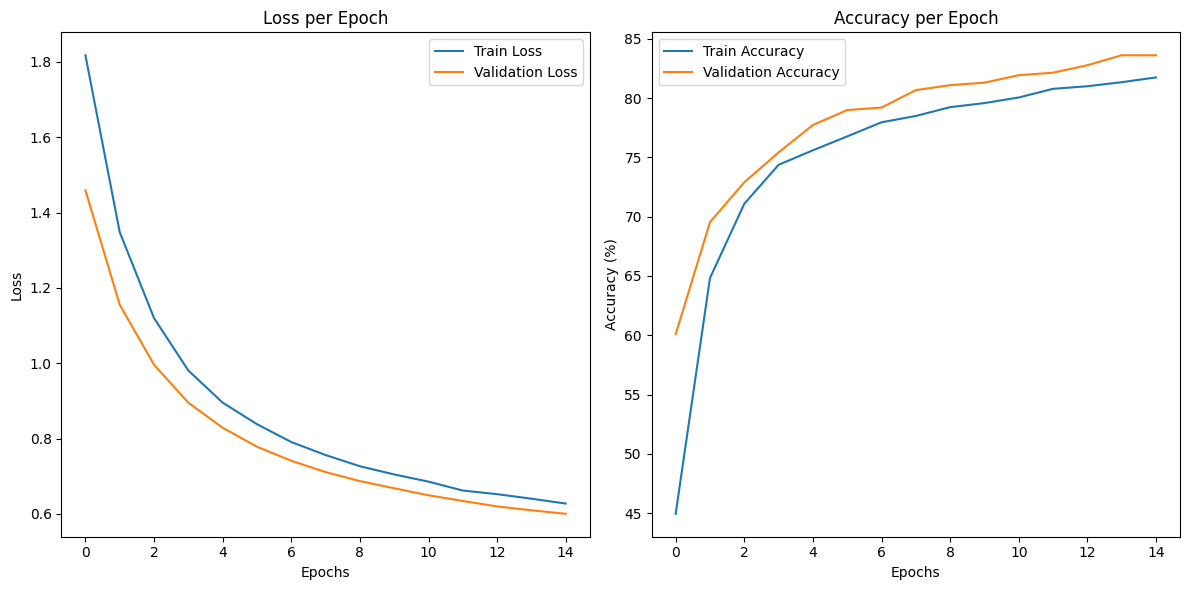

In [11]:
from torchvision.models import Swin_B_Weights

# Load the pre-trained Swin Transformer
model_name = "Swin_B"

# Number of epochs
num_epochs = 15

# Carica il modello Swin Transformer senza pesi
model = models.swin_b(weights=Swin_B_Weights.DEFAULT)

# Freeze the weights of the pre-trained backbone
for param in model.parameters():
    param.requires_grad = False

# Modify the final layer to match our number of classes (9 in this case)
model.head = nn.Linear(model.head.in_features, num_classes)

# Move the model to the GPU
model = model.to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
learning_rate = 1e-4
weight_decay = 1e-2
optimizer = optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()), 
    lr=learning_rate, 
    weight_decay=weight_decay
)

# Train the model
train_losses, val_losses, train_accuracies, val_accuracies = train_model(
    model, train_loader, val_loader, criterion, optimizer, num_epochs=num_epochs
)

# Save the trained model to a file
model_save_path = '/kaggle/working/trained_swin_b_model.pth'
torch.save(model.state_dict(), model_save_path)

print(f"Model saved to {model_save_path}")

# Update metrics dataset
update_training_results_csv(model_name, "adam", learning_rate, weight_decay, train_losses, val_losses, train_accuracies, val_accuracies)

# Plot losses and accuracies
plot_training_validation_metrics(train_losses, val_losses, train_accuracies, val_accuracies)

### Vision Transformer ViT_L_16

Validation Epoch 1/15: 100%|██████████| 8/8 [00:12<00:00,  1.52s/batch, accuracy=68.9, loss=1.15] 


Epoch 1/15, Train Loss: 1.6046, Train Accuracy: 51.08%, Val Loss: 1.1517, Val Accuracy: 68.91%


Validation Epoch 2/15: 100%|██████████| 8/8 [00:12<00:00,  1.52s/batch, accuracy=76.1, loss=0.859]


Epoch 2/15, Train Loss: 0.9966, Train Accuracy: 74.53%, Val Loss: 0.8594, Val Accuracy: 76.05%


Validation Epoch 3/15: 100%|██████████| 8/8 [00:12<00:00,  1.55s/batch, accuracy=77.5, loss=0.734]


Epoch 3/15, Train Loss: 0.7861, Train Accuracy: 78.95%, Val Loss: 0.7338, Val Accuracy: 77.52%


Validation Epoch 4/15: 100%|██████████| 8/8 [00:12<00:00,  1.52s/batch, accuracy=80.5, loss=0.659] 


Epoch 4/15, Train Loss: 0.6753, Train Accuracy: 81.38%, Val Loss: 0.6595, Val Accuracy: 80.46%


Validation Epoch 5/15: 100%|██████████| 8/8 [00:12<00:00,  1.51s/batch, accuracy=80.7, loss=0.61]  


Epoch 5/15, Train Loss: 0.6029, Train Accuracy: 83.14%, Val Loss: 0.6100, Val Accuracy: 80.67%


Validation Epoch 6/15: 100%|██████████| 8/8 [00:12<00:00,  1.53s/batch, accuracy=81.5, loss=0.575] 


Epoch 6/15, Train Loss: 0.5520, Train Accuracy: 84.39%, Val Loss: 0.5750, Val Accuracy: 81.51%


Validation Epoch 7/15: 100%|██████████| 8/8 [00:12<00:00,  1.51s/batch, accuracy=81.7, loss=0.546] 


Epoch 7/15, Train Loss: 0.5135, Train Accuracy: 85.62%, Val Loss: 0.5455, Val Accuracy: 81.72%


Validation Epoch 8/15: 100%|██████████| 8/8 [00:12<00:00,  1.54s/batch, accuracy=82.8, loss=0.522] 


Epoch 8/15, Train Loss: 0.4830, Train Accuracy: 86.46%, Val Loss: 0.5223, Val Accuracy: 82.77%


Validation Epoch 9/15: 100%|██████████| 8/8 [00:12<00:00,  1.54s/batch, accuracy=83.2, loss=0.509] 


Epoch 9/15, Train Loss: 0.4543, Train Accuracy: 87.33%, Val Loss: 0.5086, Val Accuracy: 83.19%


Validation Epoch 10/15: 100%|██████████| 8/8 [00:12<00:00,  1.55s/batch, accuracy=83.4, loss=0.492] 


Epoch 10/15, Train Loss: 0.4332, Train Accuracy: 87.89%, Val Loss: 0.4919, Val Accuracy: 83.40%


Validation Epoch 11/15: 100%|██████████| 8/8 [00:12<00:00,  1.52s/batch, accuracy=83.6, loss=0.479] 


Epoch 11/15, Train Loss: 0.4152, Train Accuracy: 88.34%, Val Loss: 0.4792, Val Accuracy: 83.61%


Validation Epoch 12/15: 100%|██████████| 8/8 [00:12<00:00,  1.51s/batch, accuracy=84, loss=0.467]   


Epoch 12/15, Train Loss: 0.3978, Train Accuracy: 88.97%, Val Loss: 0.4671, Val Accuracy: 84.03%


Validation Epoch 13/15: 100%|██████████| 8/8 [00:12<00:00,  1.50s/batch, accuracy=84.5, loss=0.457] 


Epoch 13/15, Train Loss: 0.3868, Train Accuracy: 89.30%, Val Loss: 0.4575, Val Accuracy: 84.45%


Validation Epoch 14/15: 100%|██████████| 8/8 [00:12<00:00,  1.54s/batch, accuracy=84.7, loss=0.449] 


Epoch 14/15, Train Loss: 0.3731, Train Accuracy: 89.58%, Val Loss: 0.4491, Val Accuracy: 84.66%


Validation Epoch 15/15: 100%|██████████| 8/8 [00:12<00:00,  1.51s/batch, accuracy=84.9, loss=0.443] 


Epoch 15/15, Train Loss: 0.3613, Train Accuracy: 89.84%, Val Loss: 0.4425, Val Accuracy: 84.87%
Model saved to /kaggle/working/trained_vit_l_16_model.pth
Dati di training per 'ViT_L_16' aggiornati in 'training_results.csv'


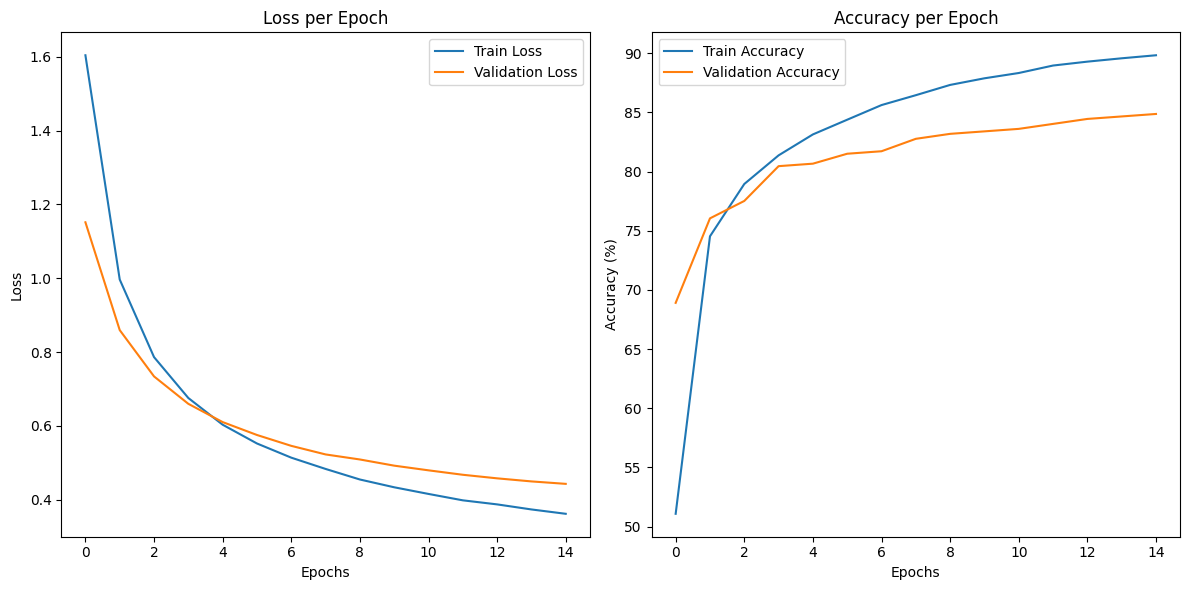

In [10]:
from torchvision.models import vit_l_16, ViT_L_16_Weights

# Load the pre-trained Vision Transformer (ViT_L_16)
model_name = "ViT_L_16"
model = vit_l_16(weights=ViT_L_16_Weights.DEFAULT)

# Number of epochs
num_epochs = 15

# Freeze the weights of the pre-trained backbone
for param in model.parameters():
    param.requires_grad = False

# Modify the final layer to match the number of classes (e.g., 9 classes in this case)
model.heads.head = nn.Linear(model.heads.head.in_features, num_classes)

# Move the model to the GPU
model = model.to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
learning_rate = 1e-4
weight_decay = 1e-2
optimizer = optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()), 
    lr=learning_rate, 
    weight_decay=weight_decay
)

# Assuming train_loader and val_loader are already defined
train_losses, val_losses, train_accuracies, val_accuracies = train_model(
    model, train_loader, val_loader, criterion, optimizer, num_epochs=num_epochs
)

# Save the trained model to a file
model_save_path = '/kaggle/working/trained_vit_l_16_model.pth'
torch.save(model.state_dict(), model_save_path)

print(f"Model saved to {model_save_path}")

# Update metrics dataset (assuming update_training_results_csv function is defined)
update_training_results_csv(model_name, "adam", learning_rate, weight_decay, train_losses, val_losses, train_accuracies, val_accuracies)

# Plot losses and accuracies
plot_training_validation_metrics(train_losses, val_losses, train_accuracies, val_accuracies)

### Efficient Net V2

Downloading: "https://download.pytorch.org/models/efficientnet_v2_s-dd5fe13b.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_v2_s-dd5fe13b.pth
100%|██████████| 82.7M/82.7M [00:00<00:00, 171MB/s] 


Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)


Validation Epoch 1/15: 100%|██████████| 8/8 [00:04<00:00,  1.88batch/s, accuracy=55.5, loss=1.5]  


Epoch 1/15, Train Loss: 1.9333, Train Accuracy: 34.86%, Val Loss: 1.4996, Val Accuracy: 55.46%


Validation Epoch 2/15: 100%|██████████| 8/8 [00:04<00:00,  1.88batch/s, accuracy=73.3, loss=0.772]


Epoch 2/15, Train Loss: 1.1192, Train Accuracy: 66.77%, Val Loss: 0.7716, Val Accuracy: 73.32%


Validation Epoch 3/15: 100%|██████████| 8/8 [00:04<00:00,  1.89batch/s, accuracy=84.2, loss=0.488] 


Epoch 3/15, Train Loss: 0.6300, Train Accuracy: 80.02%, Val Loss: 0.4880, Val Accuracy: 84.24%


Validation Epoch 4/15: 100%|██████████| 8/8 [00:04<00:00,  1.67batch/s, accuracy=87, loss=0.343]   


Epoch 4/15, Train Loss: 0.3943, Train Accuracy: 87.21%, Val Loss: 0.3434, Val Accuracy: 86.97%


Validation Epoch 5/15: 100%|██████████| 8/8 [00:04<00:00,  1.74batch/s, accuracy=89.9, loss=0.267] 


Epoch 5/15, Train Loss: 0.2729, Train Accuracy: 90.97%, Val Loss: 0.2666, Val Accuracy: 89.92%


Validation Epoch 6/15: 100%|██████████| 8/8 [00:04<00:00,  1.85batch/s, accuracy=90.8, loss=0.226] 


Epoch 6/15, Train Loss: 0.1997, Train Accuracy: 93.64%, Val Loss: 0.2261, Val Accuracy: 90.76%


Validation Epoch 7/15: 100%|██████████| 8/8 [00:04<00:00,  1.80batch/s, accuracy=92.2, loss=0.195] 


Epoch 7/15, Train Loss: 0.1442, Train Accuracy: 95.36%, Val Loss: 0.1953, Val Accuracy: 92.23%


Validation Epoch 8/15: 100%|██████████| 8/8 [00:04<00:00,  1.67batch/s, accuracy=93.7, loss=0.184] 


Epoch 8/15, Train Loss: 0.1127, Train Accuracy: 96.63%, Val Loss: 0.1836, Val Accuracy: 93.70%


Validation Epoch 9/15: 100%|██████████| 8/8 [00:04<00:00,  1.70batch/s, accuracy=93.7, loss=0.184] 


Epoch 9/15, Train Loss: 0.0892, Train Accuracy: 97.34%, Val Loss: 0.1839, Val Accuracy: 93.70%


Validation Epoch 10/15: 100%|██████████| 8/8 [00:04<00:00,  1.78batch/s, accuracy=93.9, loss=0.164] 


Epoch 10/15, Train Loss: 0.0795, Train Accuracy: 97.64%, Val Loss: 0.1642, Val Accuracy: 93.91%


Validation Epoch 11/15: 100%|██████████| 8/8 [00:04<00:00,  1.76batch/s, accuracy=93.7, loss=0.167] 


Epoch 11/15, Train Loss: 0.0657, Train Accuracy: 98.25%, Val Loss: 0.1668, Val Accuracy: 93.70%


Validation Epoch 12/15: 100%|██████████| 8/8 [00:04<00:00,  1.74batch/s, accuracy=94.1, loss=0.16]  


Epoch 12/15, Train Loss: 0.0604, Train Accuracy: 98.26%, Val Loss: 0.1605, Val Accuracy: 94.12%


Validation Epoch 13/15: 100%|██████████| 8/8 [00:04<00:00,  1.82batch/s, accuracy=94.1, loss=0.158] 


Epoch 13/15, Train Loss: 0.0534, Train Accuracy: 98.57%, Val Loss: 0.1576, Val Accuracy: 94.12%


Validation Epoch 14/15: 100%|██████████| 8/8 [00:04<00:00,  1.80batch/s, accuracy=94.1, loss=0.161] 


Epoch 14/15, Train Loss: 0.0472, Train Accuracy: 98.66%, Val Loss: 0.1613, Val Accuracy: 94.12%


Validation Epoch 15/15: 100%|██████████| 8/8 [00:04<00:00,  1.76batch/s, accuracy=93.9, loss=0.165] 


Epoch 15/15, Train Loss: 0.0472, Train Accuracy: 98.63%, Val Loss: 0.1647, Val Accuracy: 93.91%
Model saved to /kaggle/working/trained_EfficientNetV2_model.pth
Dati di training per 'EfficientNetV2' aggiornati in 'training_results.csv'


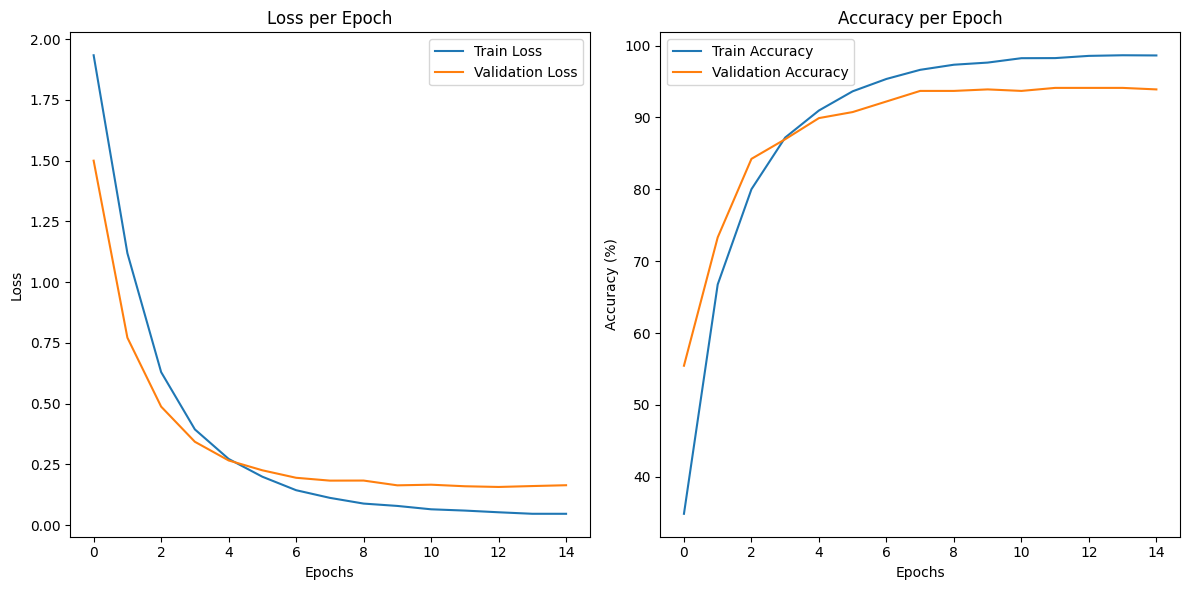

In [10]:
from torchvision.models import efficientnet_v2_s, EfficientNet_V2_S_Weights

# Load the pre-trained Efficient Net
model_name = "EfficientNetV2"
model = efficientnet_v2_s(weights=EfficientNet_V2_S_Weights.DEFAULT)

# Number of epochs
num_epochs = 15

# Inspect the model's classifier to identify the final layer
print(model.classifier)

# Extract the input features of the last layer in the classifier
in_features = model.classifier[-1].in_features  # Access the last layer of the Sequential module
num_classes = 9  # Change this to your specific number of classes

# Modify the classifier
model.classifier[-1] = nn.Linear(in_features, num_classes)

# Enable gradient computation for the classifier
for param in model.classifier[-1].parameters():
    param.requires_grad = True

# Move the model to the GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Loss function and optimizer
weights = torch.tensor(class_weights.copy(), dtype=torch.float32).to(device)  # Custom weights
criterion = nn.CrossEntropyLoss(weight=weights)
learning_rate = 1e-5
weight_decay = 1e-2
optimizer = torch.optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()), 
    lr=learning_rate, 
    weight_decay=weight_decay
)

# Training the model
train_losses, val_losses, train_accuracies, val_accuracies = train_model(
    model, train_loader, val_loader, criterion, optimizer, num_epochs=num_epochs
)

# Save the model
model_save_path = f"/kaggle/working/trained_{model_name}_model.pth"
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

# Update metrics dataset
update_training_results_csv(model_name, "adam", learning_rate, weight_decay, train_losses, val_losses, train_accuracies, val_accuracies)

# Plot training and validation metrics
plot_training_validation_metrics(train_losses, val_losses, train_accuracies, val_accuracies)

### Custom CNN

In [12]:
class CNNModel(nn.Module):
    def __init__(self, num_classes=9):
        super(CNNModel, self).__init__()
        
        # Base convolutional block
        self.conv_block1 = self._create_conv_block(3, 64)  # 64 filters
        self.conv_block2 = self._create_conv_block(64, 128)  # 128 filters
        self.conv_block3 = self._create_conv_block(128, 256)  # 256 filters
        self.conv_block4 = self._create_conv_block(256, 512)  # 512 filters
        self.conv_block5 = self._create_conv_block(512, 512)  # Additional 512 filters
        
        # Global Average Pooling layer
        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)
        
        # Fully connected layers
        self.fc1 = nn.Linear(512, 512)  # First dense layer
        self.fc2 = nn.Linear(512, num_classes)  # Output layer for classification
        self.dropout = nn.Dropout(0.3)  # Dropout for regularization

    def _create_conv_block(self, in_channels, out_channels):
        """Creates a standard convolutional block."""
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),  # First convolution
            nn.BatchNorm2d(out_channels),  # Batch normalization
            nn.ReLU(inplace=True),  # Activation function
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),  # Second convolution
            nn.BatchNorm2d(out_channels),  # Batch normalization
            nn.ReLU(inplace=True),  # Activation function
            nn.MaxPool2d(kernel_size=2, stride=2)  # Max pooling to reduce spatial dimensions
        )

    def forward(self, x):
        # Pass input through the convolutional blocks
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.conv_block3(x)
        x = self.conv_block4(x)
        x = self.conv_block5(x)
        
        # Global Average Pooling
        x = self.global_avg_pool(x)
        x = x.view(x.size(0), -1)  # Flatten to prepare for dense layers
        
        # Pass through dense layers
        x = nn.functional.relu(self.fc1(x))  # First fully connected layer with ReLU activation
        x = self.dropout(x)  # Apply dropout
        x = self.fc2(x)  # Output layer for predictions
        
        return x

Using device: cuda


Validation Epoch 1/15: 100%|██████████| 8/8 [00:04<00:00,  1.70batch/s, accuracy=60.9, loss=1.12] 


Epoch 1/15, Train Loss: 1.4673, Train Accuracy: 48.82%, Val Loss: 1.1199, Val Accuracy: 60.92%


Validation Epoch 2/15: 100%|██████████| 8/8 [00:04<00:00,  1.78batch/s, accuracy=70.4, loss=0.91] 


Epoch 2/15, Train Loss: 1.0540, Train Accuracy: 63.12%, Val Loss: 0.9099, Val Accuracy: 70.38%


Validation Epoch 3/15: 100%|██████████| 8/8 [00:04<00:00,  1.64batch/s, accuracy=73.1, loss=0.779] 


Epoch 3/15, Train Loss: 0.8734, Train Accuracy: 69.53%, Val Loss: 0.7788, Val Accuracy: 73.11%


Validation Epoch 4/15: 100%|██████████| 8/8 [00:04<00:00,  1.72batch/s, accuracy=73.9, loss=0.743] 


Epoch 4/15, Train Loss: 0.7574, Train Accuracy: 73.72%, Val Loss: 0.7431, Val Accuracy: 73.95%


Validation Epoch 5/15: 100%|██████████| 8/8 [00:04<00:00,  1.83batch/s, accuracy=75.8, loss=0.681] 


Epoch 5/15, Train Loss: 0.6709, Train Accuracy: 76.26%, Val Loss: 0.6810, Val Accuracy: 75.84%


Validation Epoch 6/15: 100%|██████████| 8/8 [00:04<00:00,  1.80batch/s, accuracy=80.7, loss=0.58]  


Epoch 6/15, Train Loss: 0.5987, Train Accuracy: 79.22%, Val Loss: 0.5804, Val Accuracy: 80.67%


Validation Epoch 7/15: 100%|██████████| 8/8 [00:04<00:00,  1.73batch/s, accuracy=78.6, loss=0.561]


Epoch 7/15, Train Loss: 0.5393, Train Accuracy: 80.95%, Val Loss: 0.5613, Val Accuracy: 78.57%


Validation Epoch 8/15: 100%|██████████| 8/8 [00:05<00:00,  1.60batch/s, accuracy=82.6, loss=0.551] 


Epoch 8/15, Train Loss: 0.5027, Train Accuracy: 82.32%, Val Loss: 0.5508, Val Accuracy: 82.56%


Validation Epoch 9/15: 100%|██████████| 8/8 [00:04<00:00,  1.75batch/s, accuracy=82.1, loss=0.478]


Epoch 9/15, Train Loss: 0.4615, Train Accuracy: 83.59%, Val Loss: 0.4784, Val Accuracy: 82.14%


Validation Epoch 10/15: 100%|██████████| 8/8 [00:05<00:00,  1.58batch/s, accuracy=83.2, loss=0.527] 


Epoch 10/15, Train Loss: 0.4325, Train Accuracy: 84.72%, Val Loss: 0.5267, Val Accuracy: 83.19%


Validation Epoch 11/15: 100%|██████████| 8/8 [00:05<00:00,  1.55batch/s, accuracy=81.9, loss=0.485] 


Epoch 11/15, Train Loss: 0.3911, Train Accuracy: 86.23%, Val Loss: 0.4846, Val Accuracy: 81.93%


Validation Epoch 12/15: 100%|██████████| 8/8 [00:04<00:00,  1.75batch/s, accuracy=83.8, loss=0.452] 


Epoch 12/15, Train Loss: 0.3636, Train Accuracy: 87.20%, Val Loss: 0.4517, Val Accuracy: 83.82%


Validation Epoch 13/15: 100%|██████████| 8/8 [00:04<00:00,  1.67batch/s, accuracy=80.7, loss=0.528] 


Epoch 13/15, Train Loss: 0.3533, Train Accuracy: 87.55%, Val Loss: 0.5283, Val Accuracy: 80.67%


Validation Epoch 14/15: 100%|██████████| 8/8 [00:04<00:00,  1.65batch/s, accuracy=84.2, loss=0.407] 


Epoch 14/15, Train Loss: 0.3264, Train Accuracy: 88.48%, Val Loss: 0.4069, Val Accuracy: 84.24%


Validation Epoch 15/15: 100%|██████████| 8/8 [00:05<00:00,  1.56batch/s, accuracy=85.3, loss=0.435] 


Epoch 15/15, Train Loss: 0.3032, Train Accuracy: 89.34%, Val Loss: 0.4348, Val Accuracy: 85.29%
Model saved to /kaggle/working/trained_Custom CNN_model.pth
Dati di training per 'Custom CNN' aggiornati in 'training_results.csv'


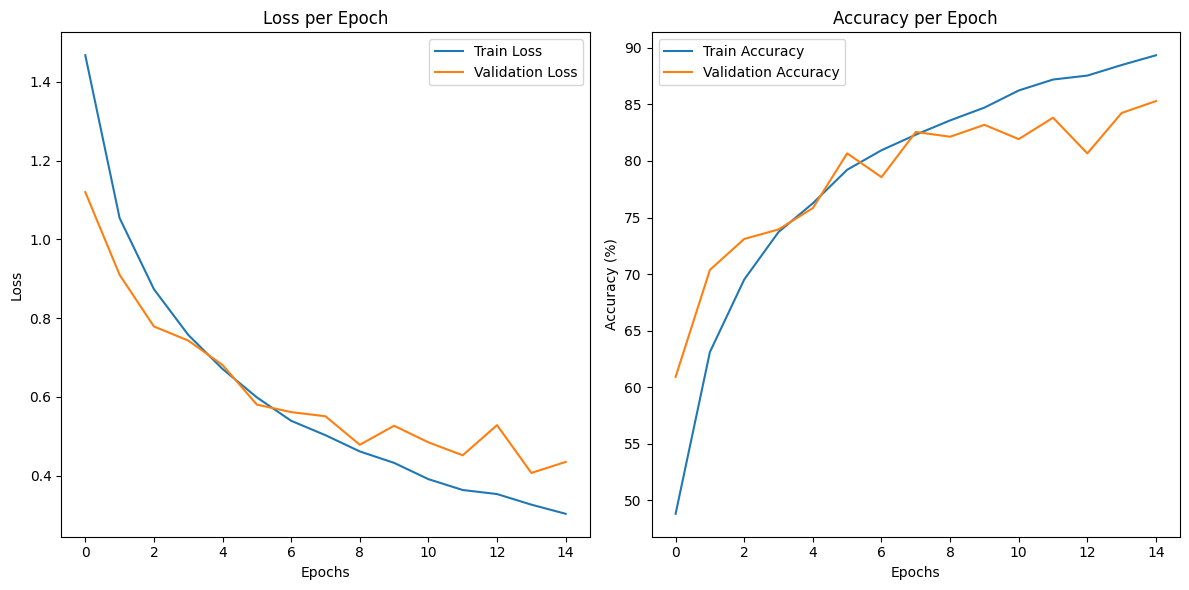

In [9]:
# Model instance
model = CNNModel(num_classes=9)

#Model's Name
model_name = "Custom CNN"

# Number of epochs
num_epochs = 15

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Convert weights to the device
weights = torch.tensor(class_weights.copy(), dtype=torch.float32).to(device)  # Customize the weights
criterion = nn.CrossEntropyLoss(weight=weights)

# Move model to the device
model = model.to(device)

# Optimizer
learning_rate = 1e-5
weight_decay = 1e-2
optimizer = optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=learning_rate,
    weight_decay=weight_decay
)

# Learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

# Model training
train_losses, val_losses, train_accuracies, val_accuracies = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=num_epochs
)

# Save the model
model_save_path = f"/kaggle/working/trained_{model_name}_model.pth"
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

# Update metrics dataset
update_training_results_csv(model_name, "adam", learning_rate, weight_decay, train_losses, val_losses, train_accuracies, val_accuracies)

# Plot training and validation metrics
plot_training_validation_metrics(
    train_losses=train_losses,
    val_losses=val_losses,
    train_accuracies=train_accuracies,
    val_accuracies=val_accuracies
)

## Evaluation on Test set

Evaluating model: trained_VGG-16_model.pth
Evaluating model: trained_MobileNetV2_model.pth
Evaluating model: trained_Custom CNN_model.pth
Evaluating model: trained_EfficientNetV2_model.pth
Evaluating model: trained_ResNet50_model.pth
Evaluating model: trained_DenseNet121_model.pth
Evaluating model: trained_vit_l_16_model.pth
Evaluating model: trained_swin_b_model.pth


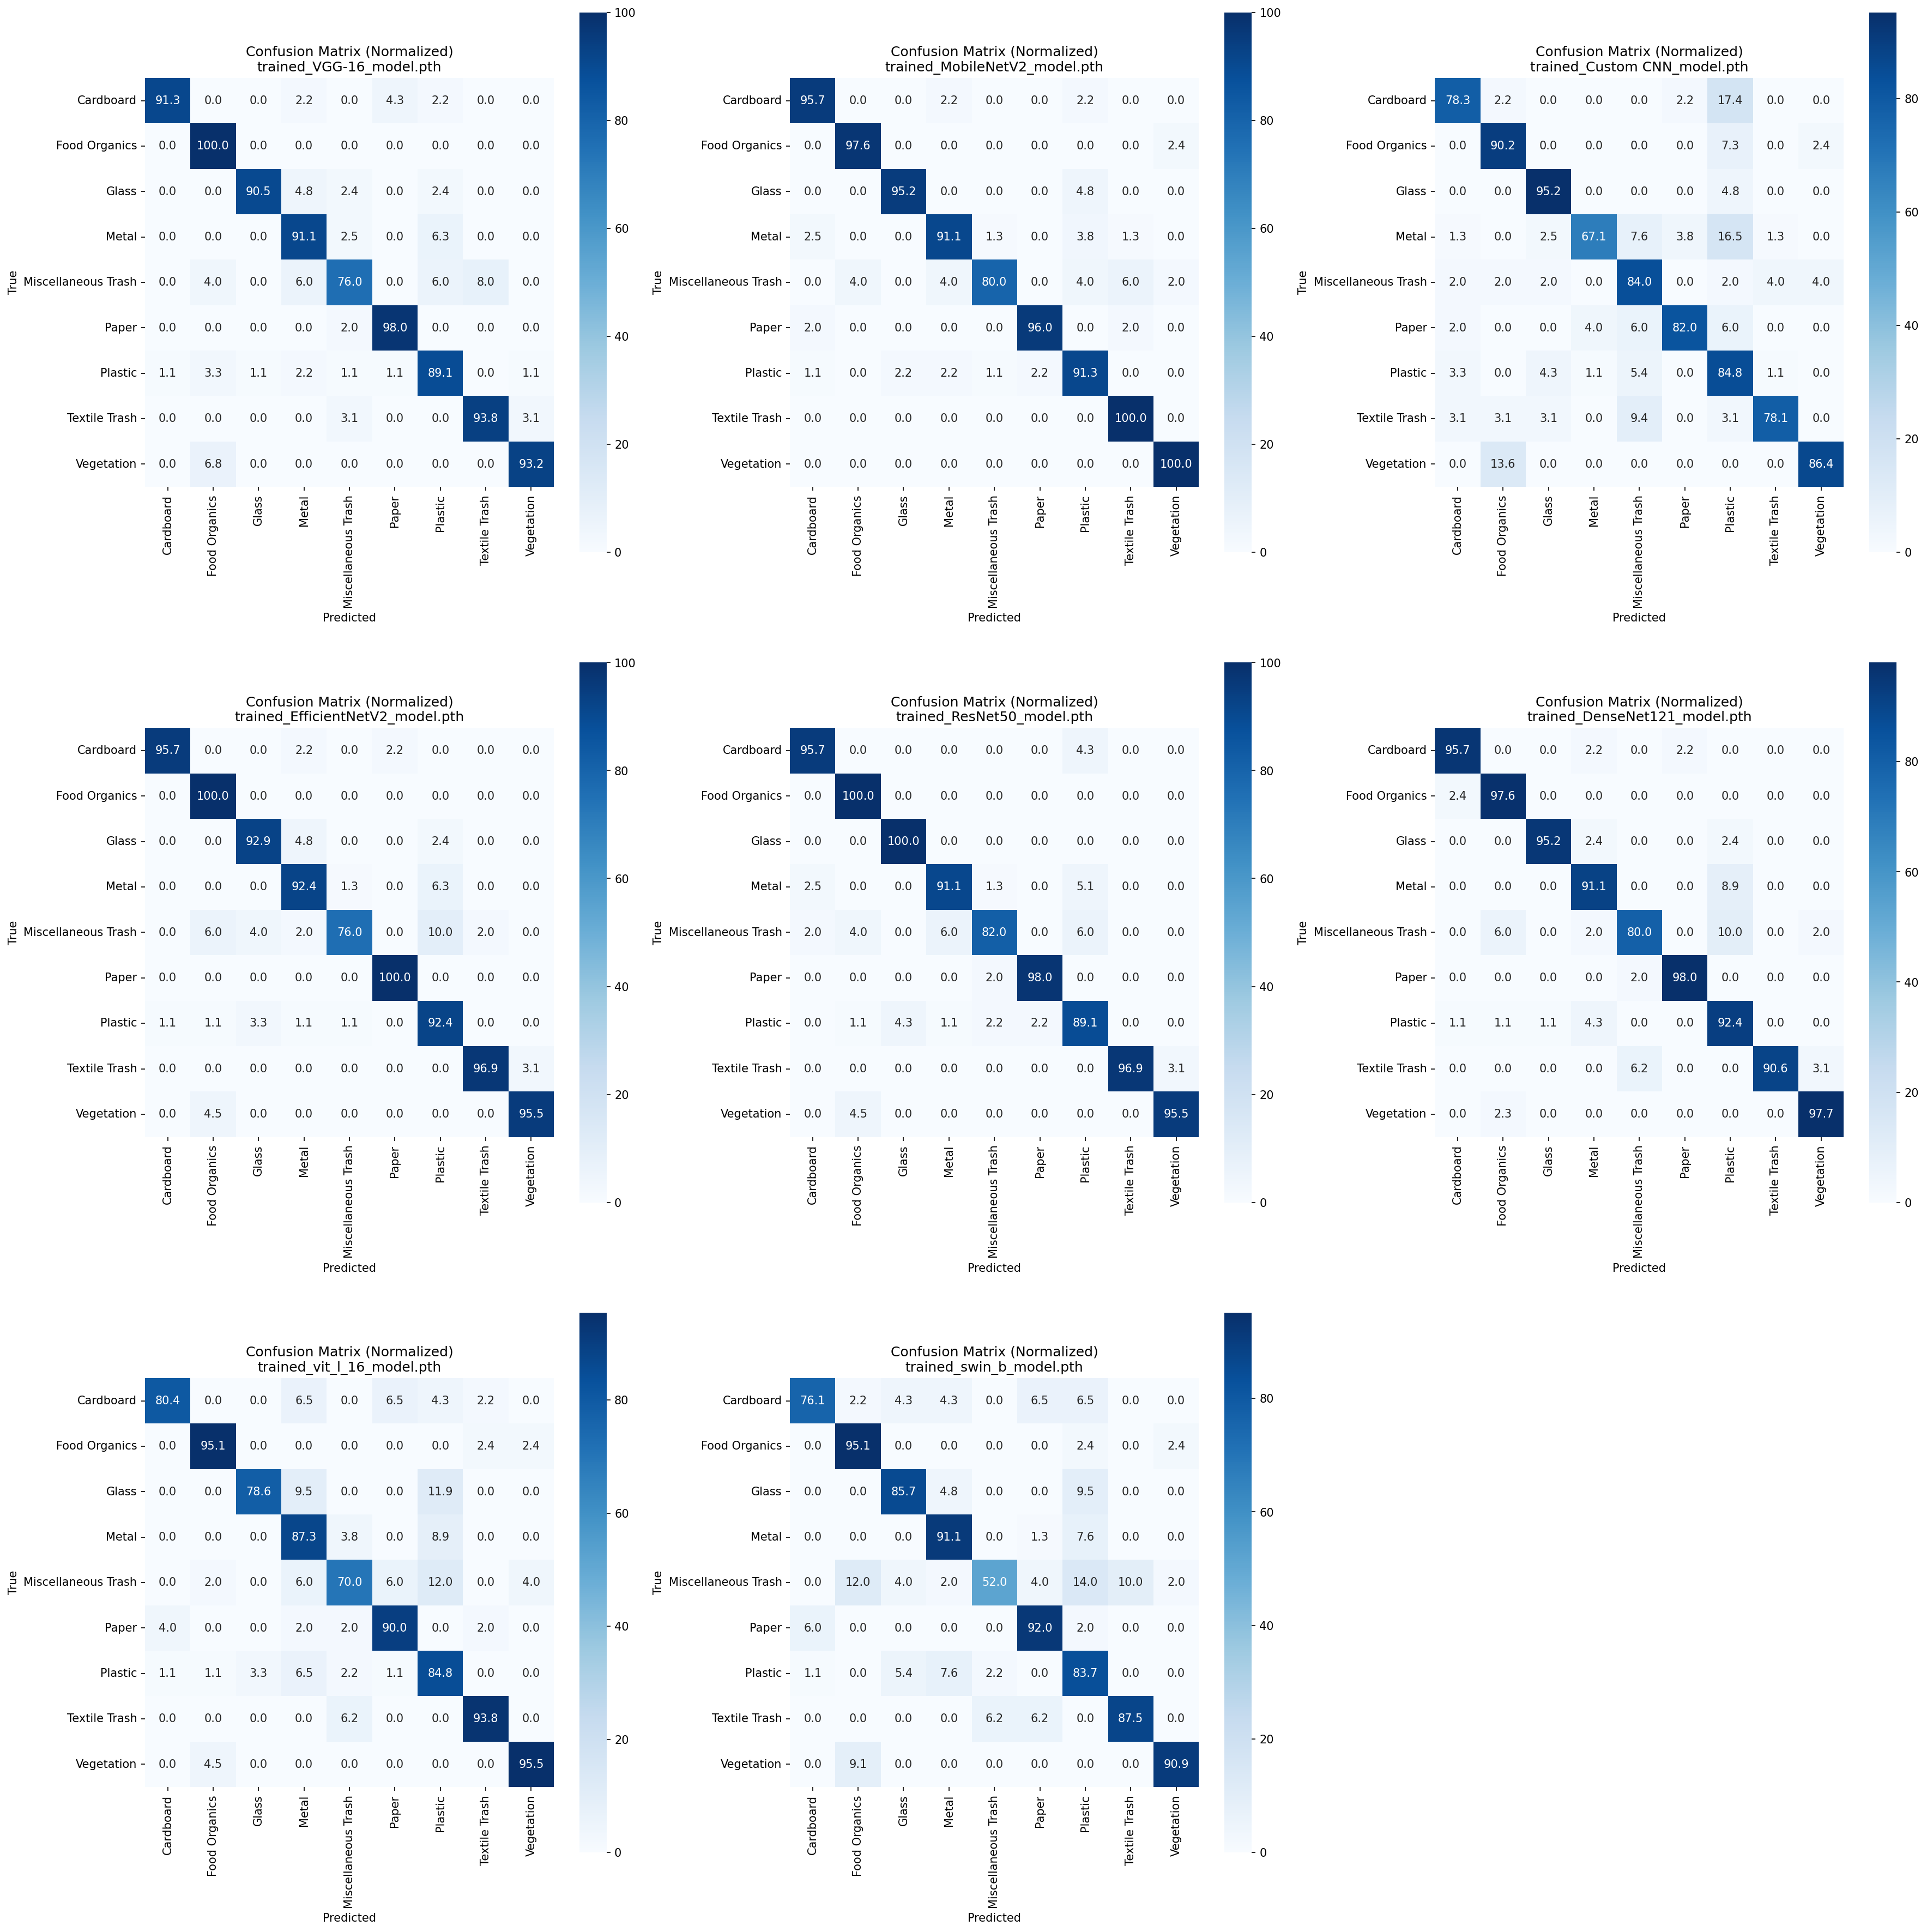

Classification Report for trained_VGG-16_model.pth:

                     precision    recall  f1-score   support

          Cardboard       0.98      0.91      0.94        46
      Food Organics       0.84      1.00      0.91        41
              Glass       0.97      0.90      0.94        42
              Metal       0.90      0.91      0.91        79
Miscellaneous Trash       0.86      0.76      0.81        50
              Paper       0.94      0.98      0.96        50
            Plastic       0.89      0.89      0.89        92
      Textile Trash       0.88      0.94      0.91        32
         Vegetation       0.95      0.93      0.94        44

           accuracy                           0.91       476
          macro avg       0.91      0.91      0.91       476
       weighted avg       0.91      0.91      0.91       476



Classification Report for trained_MobileNetV2_model.pth:

                     precision    recall  f1-score   support

          Cardboard       0.9

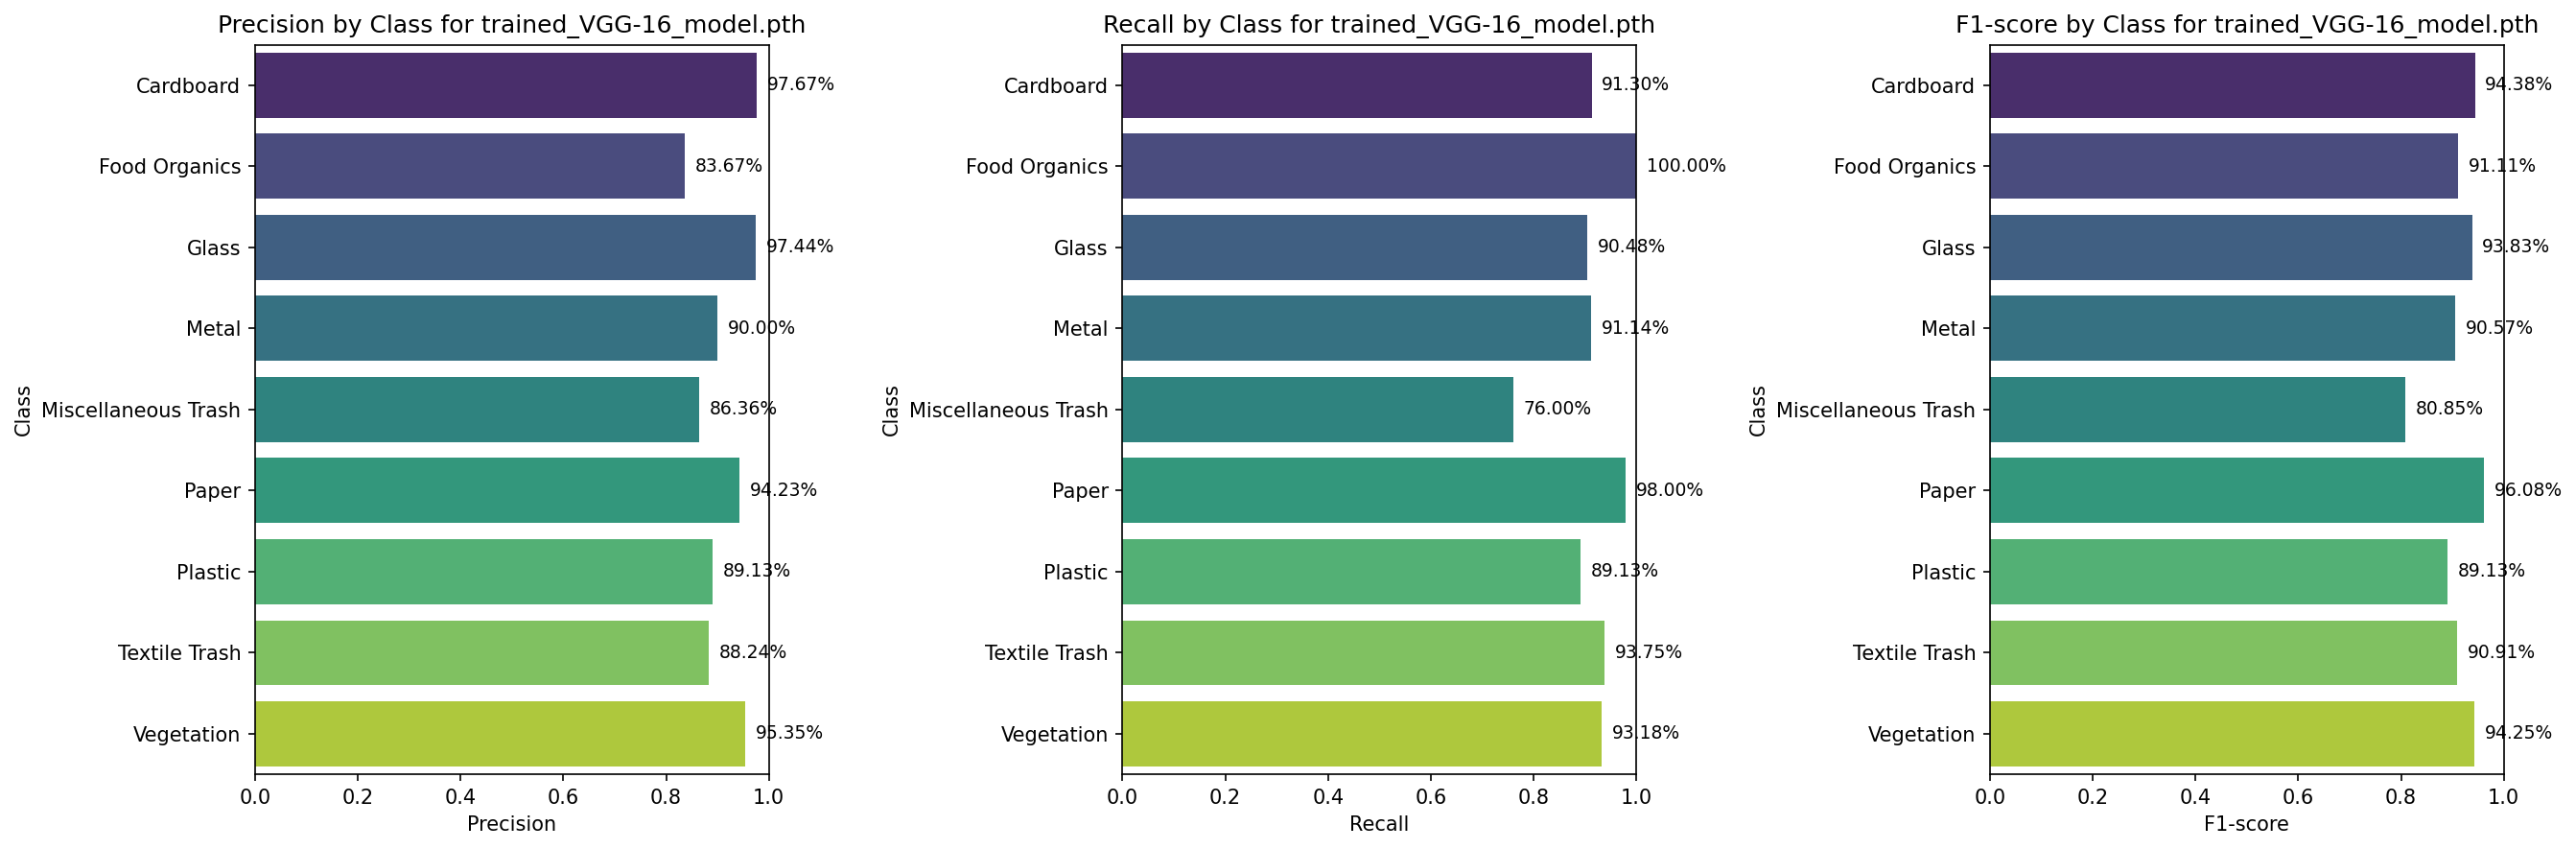

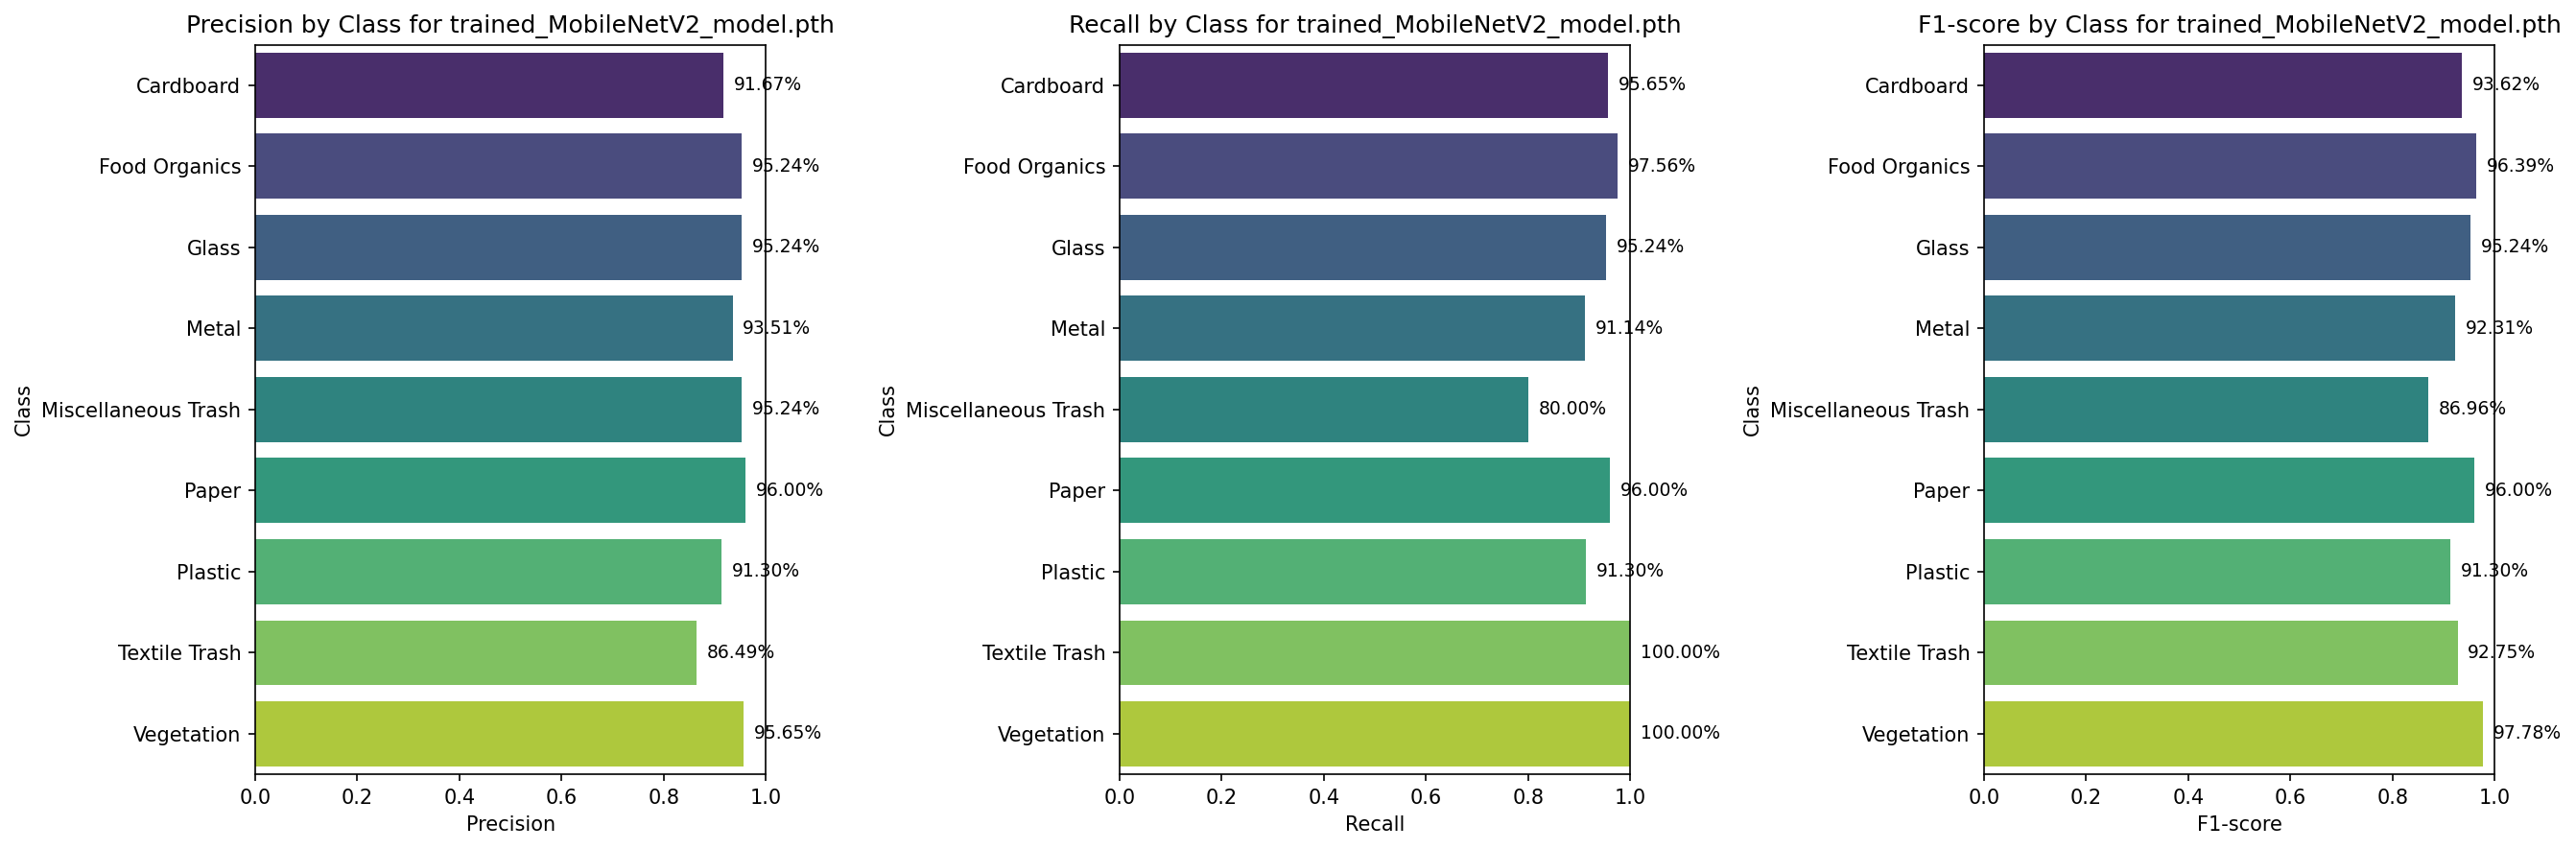

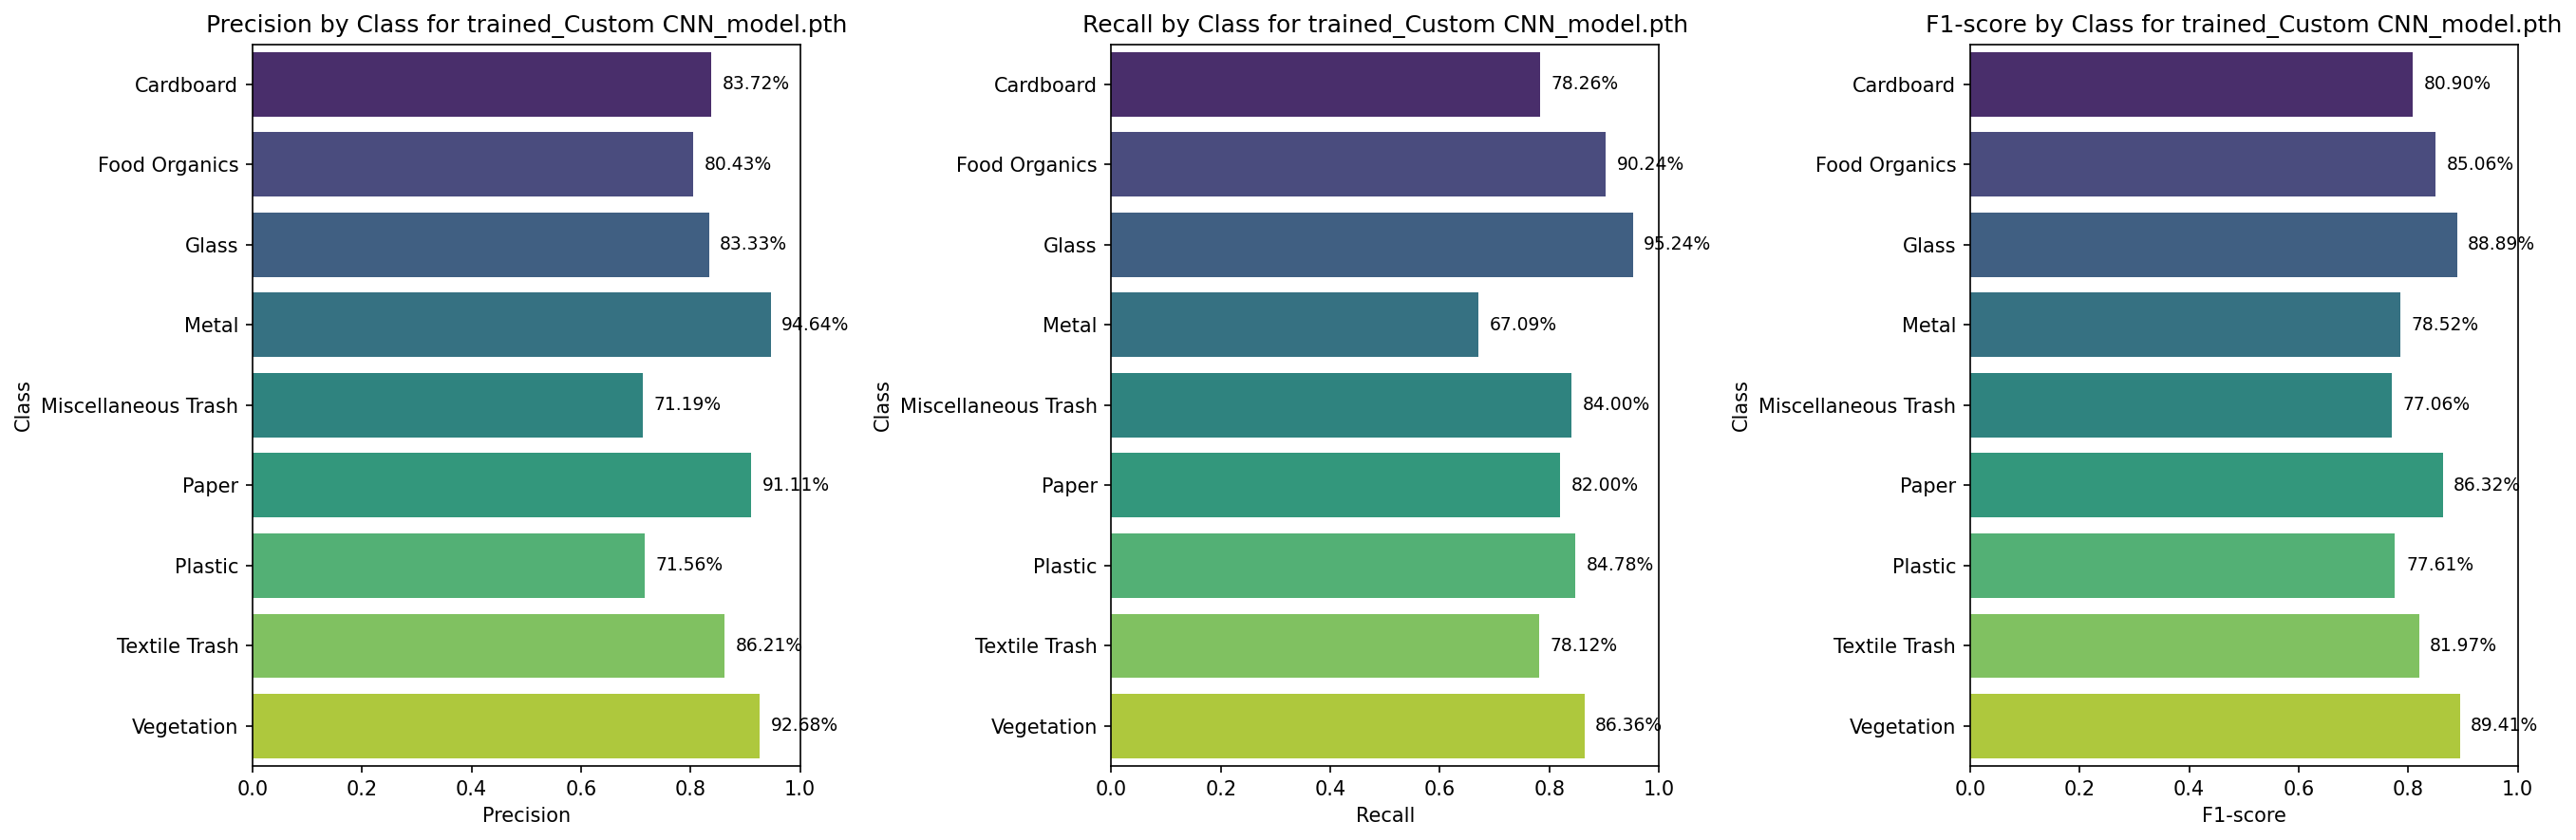

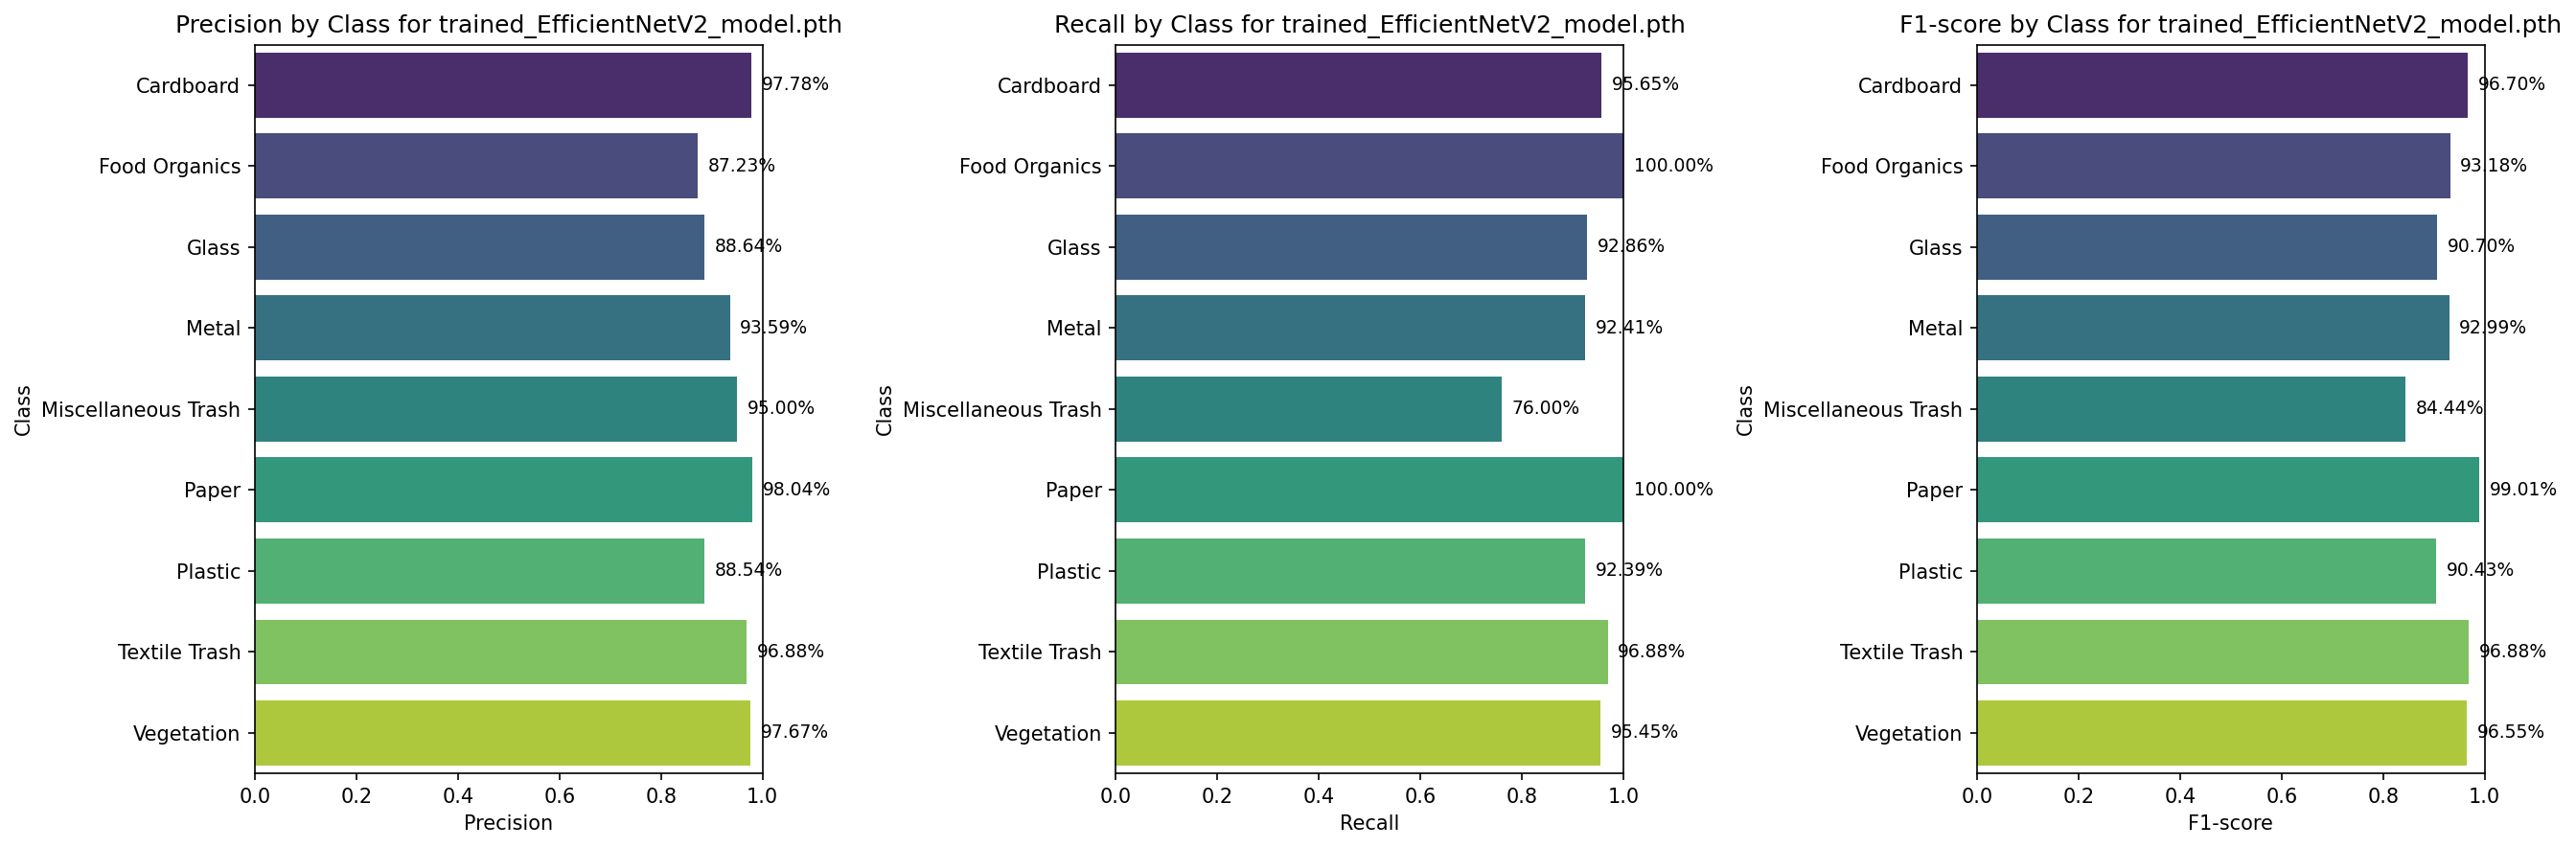

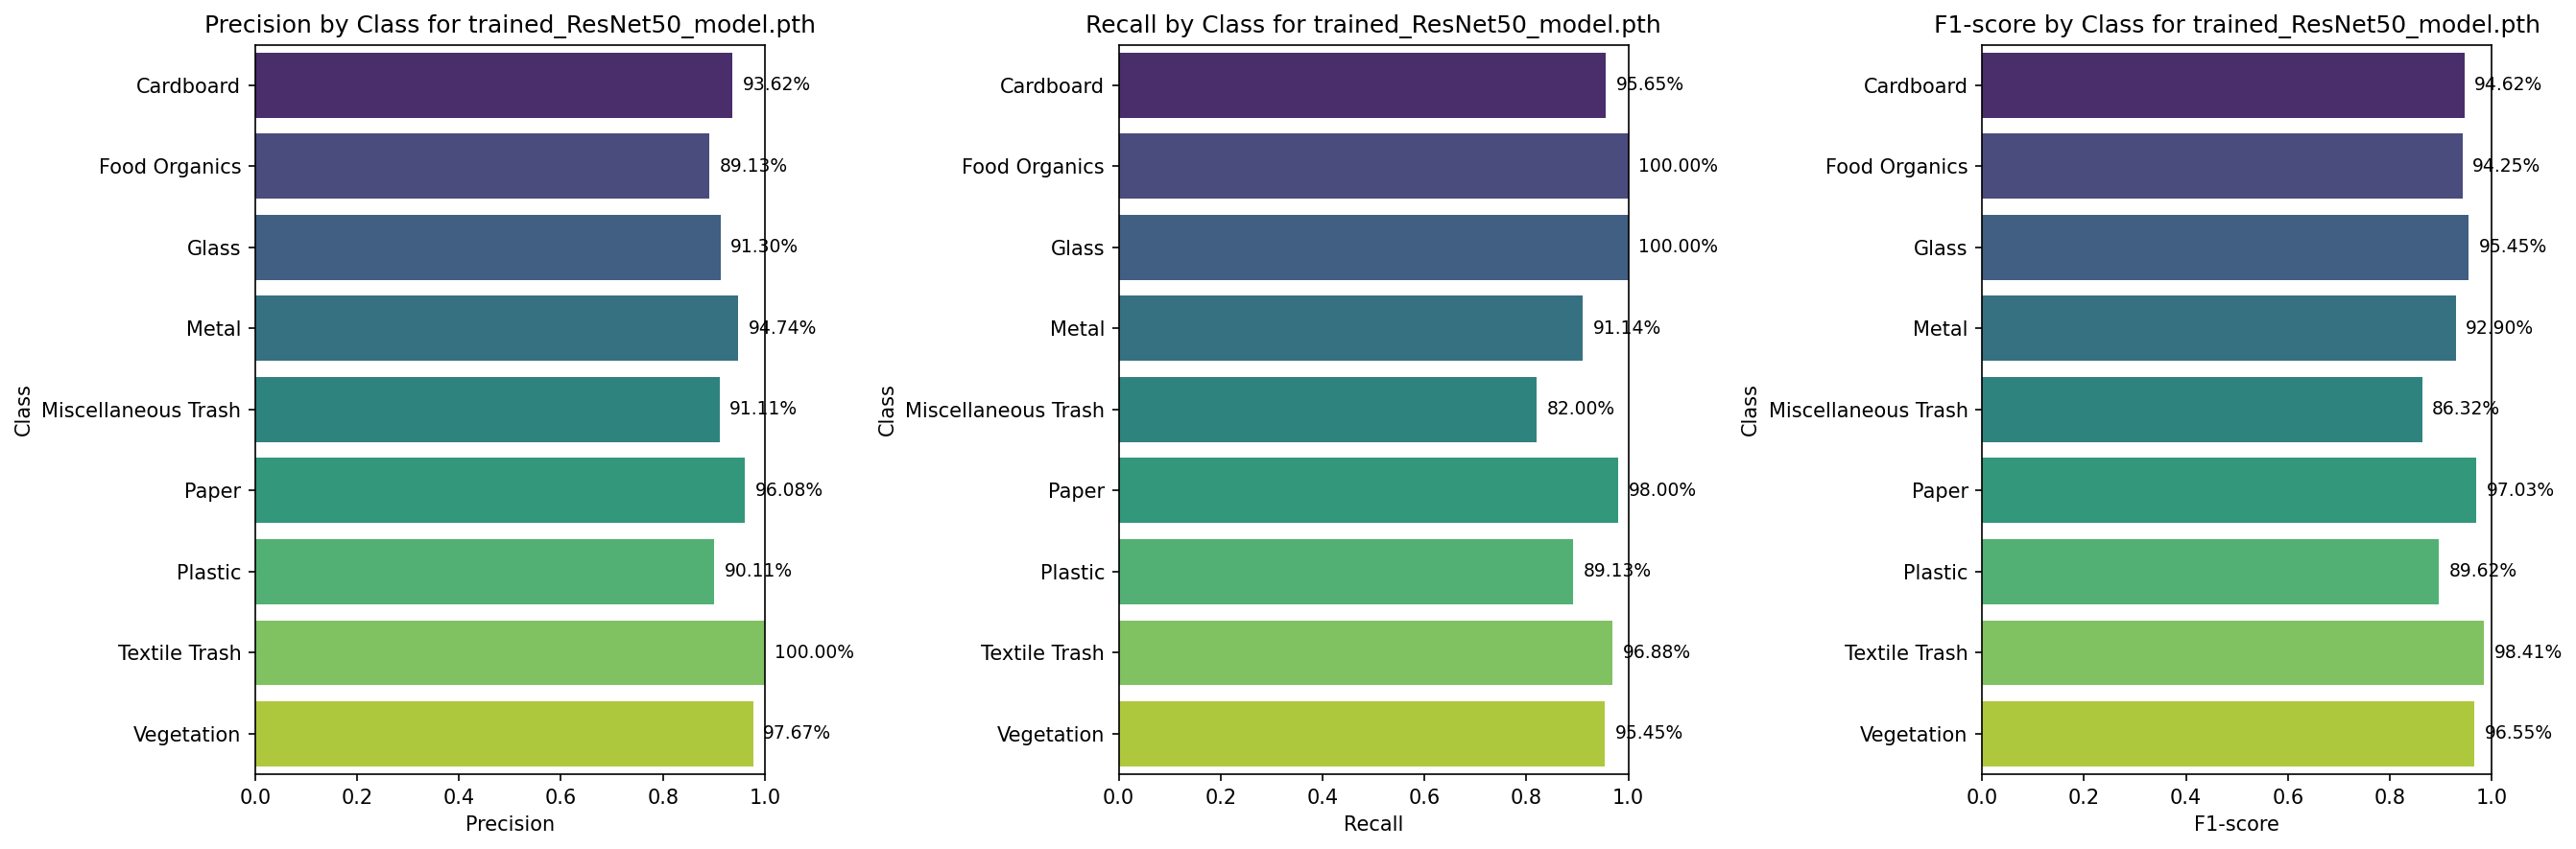

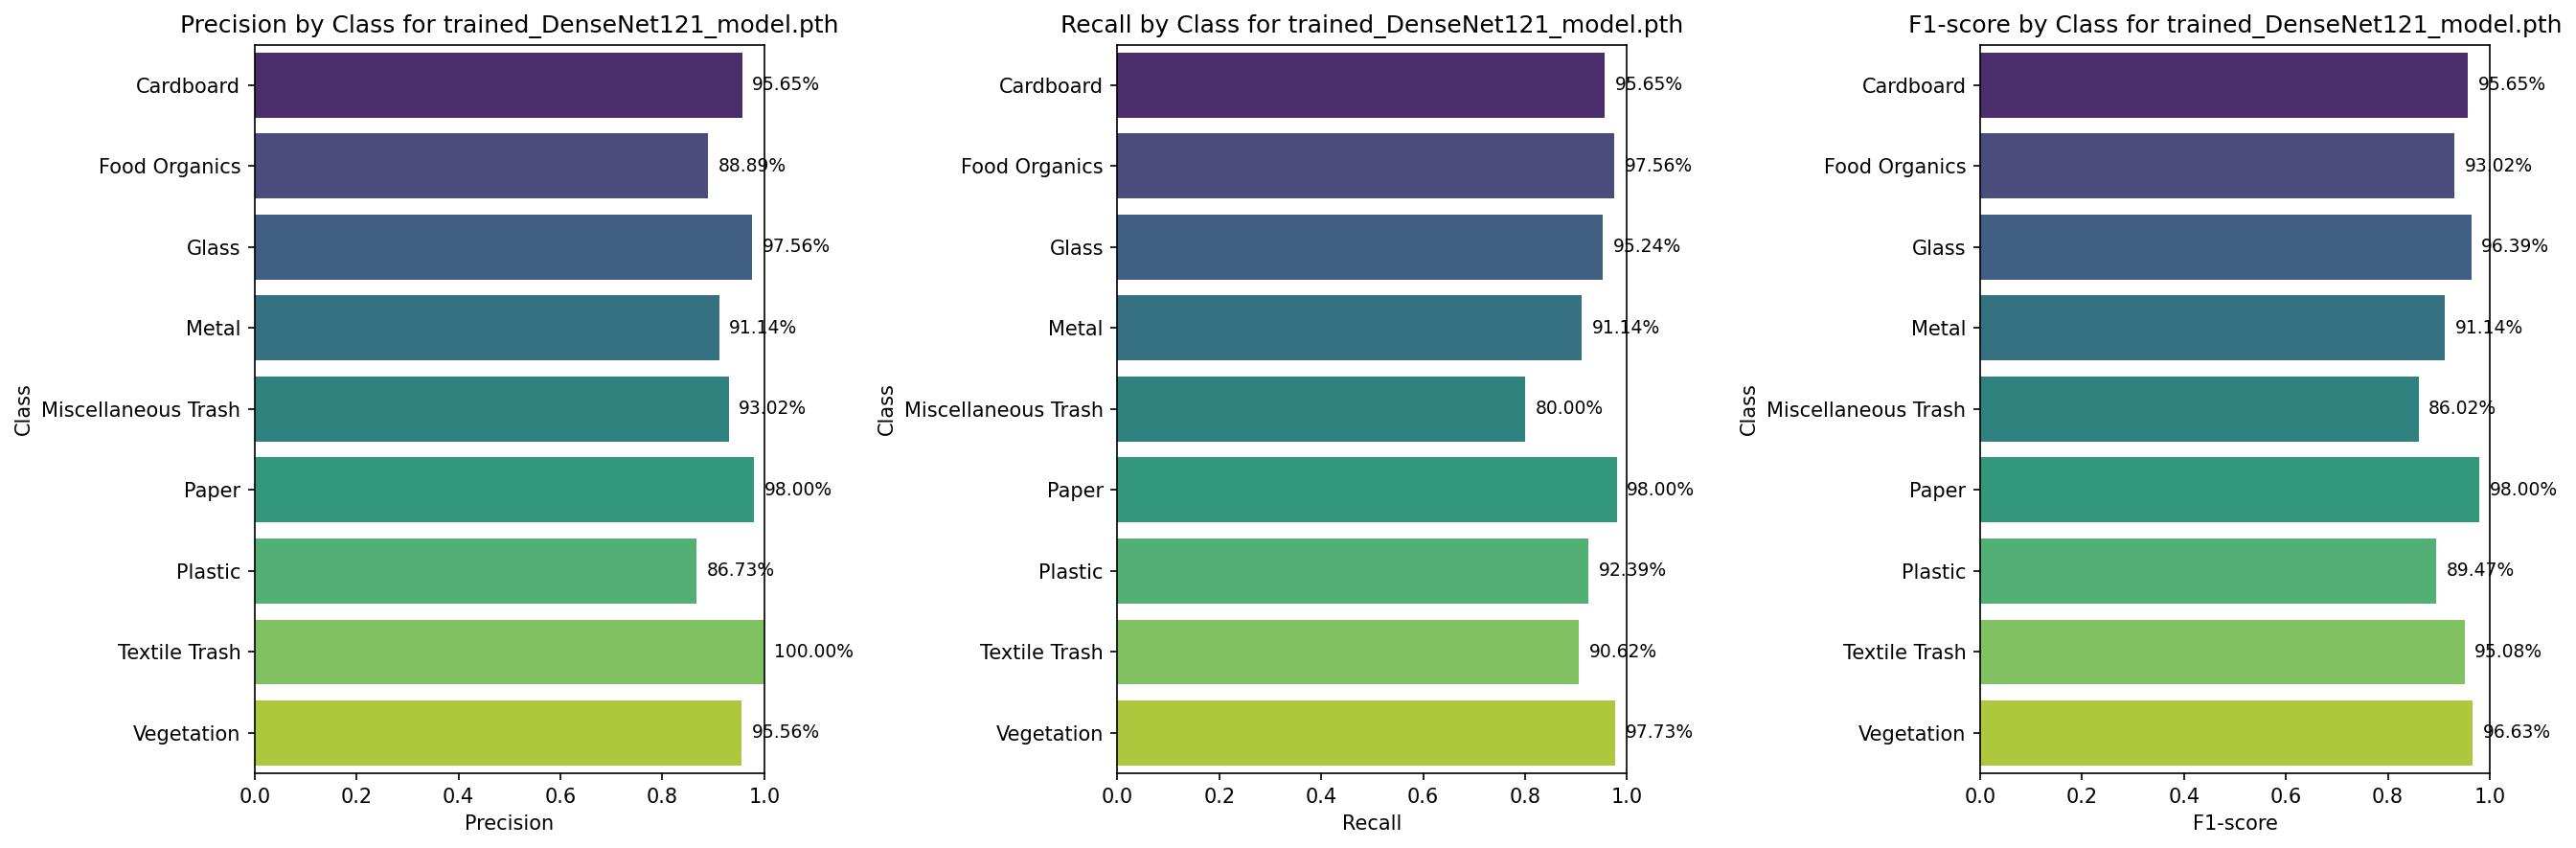

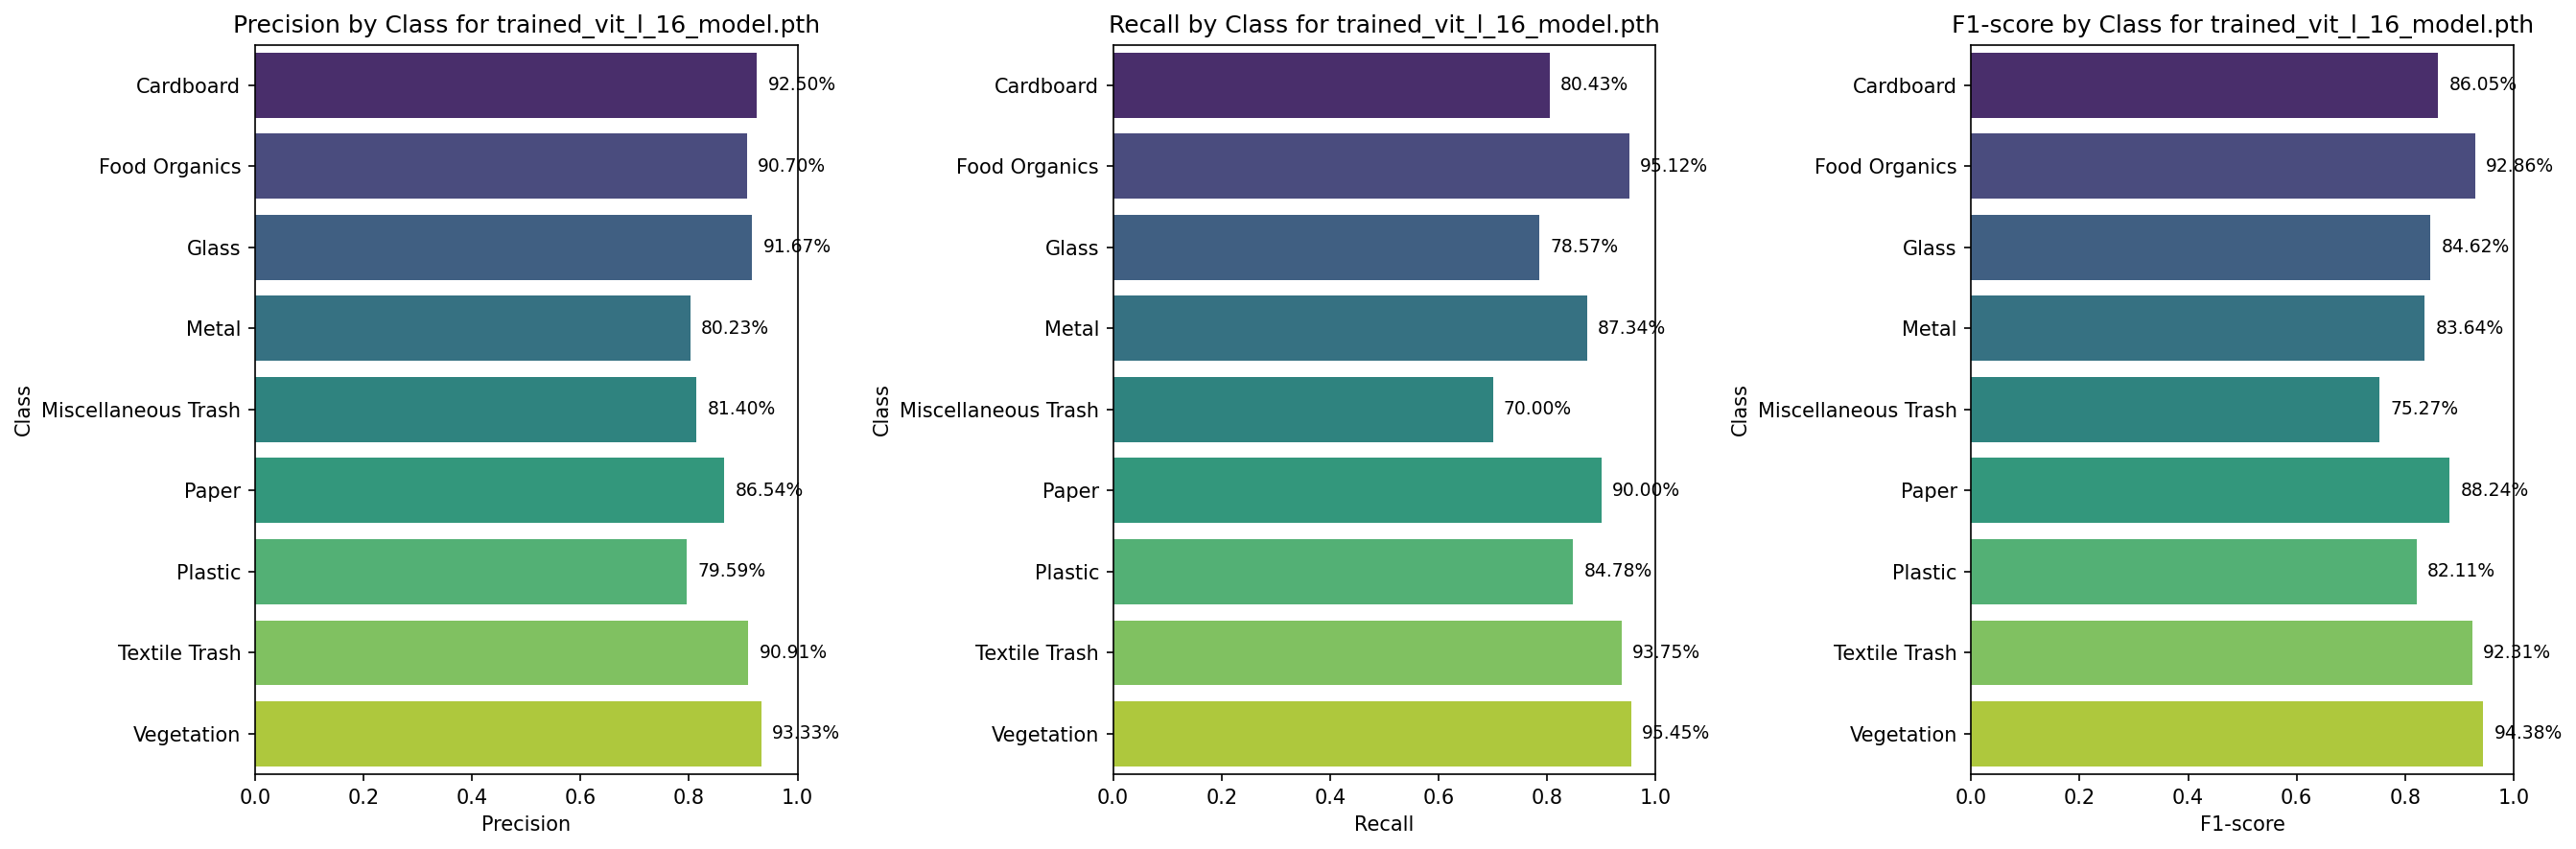

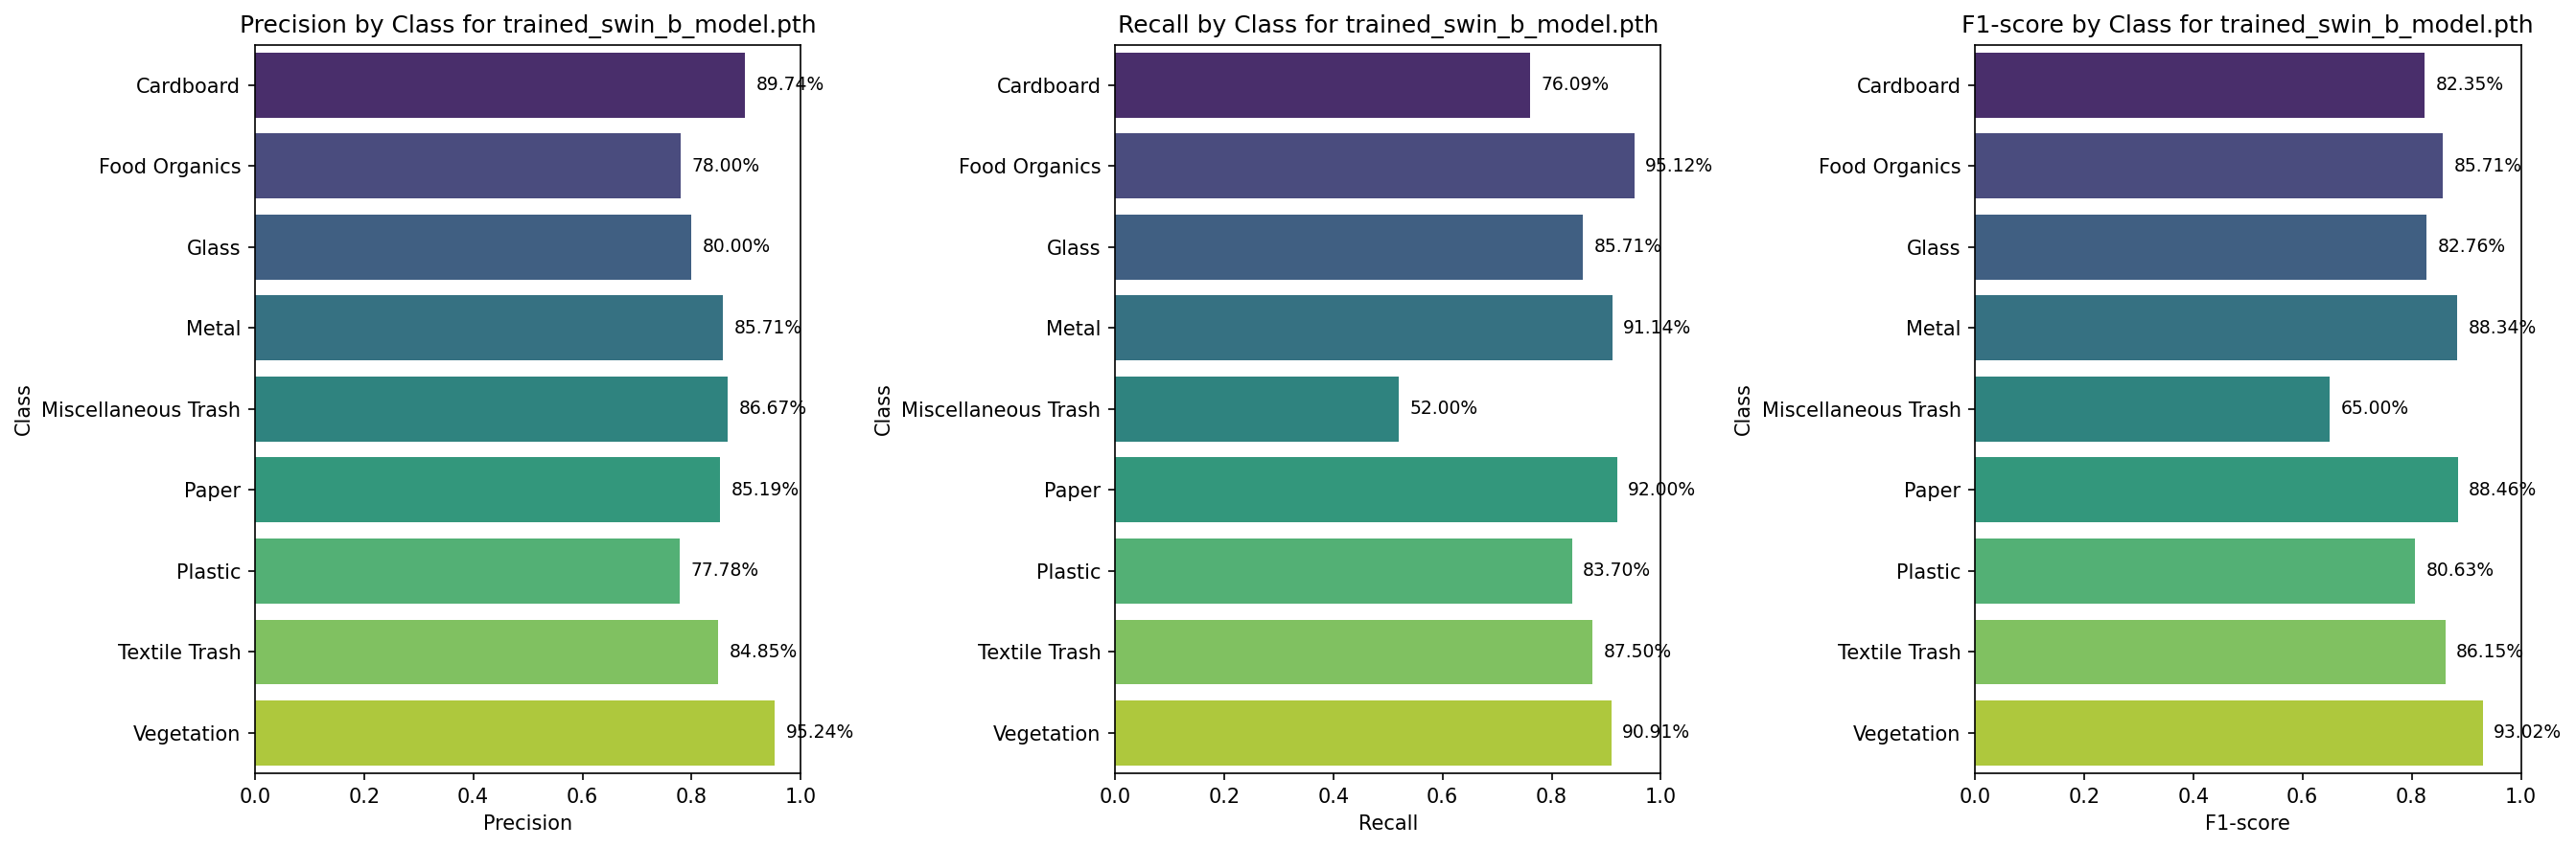

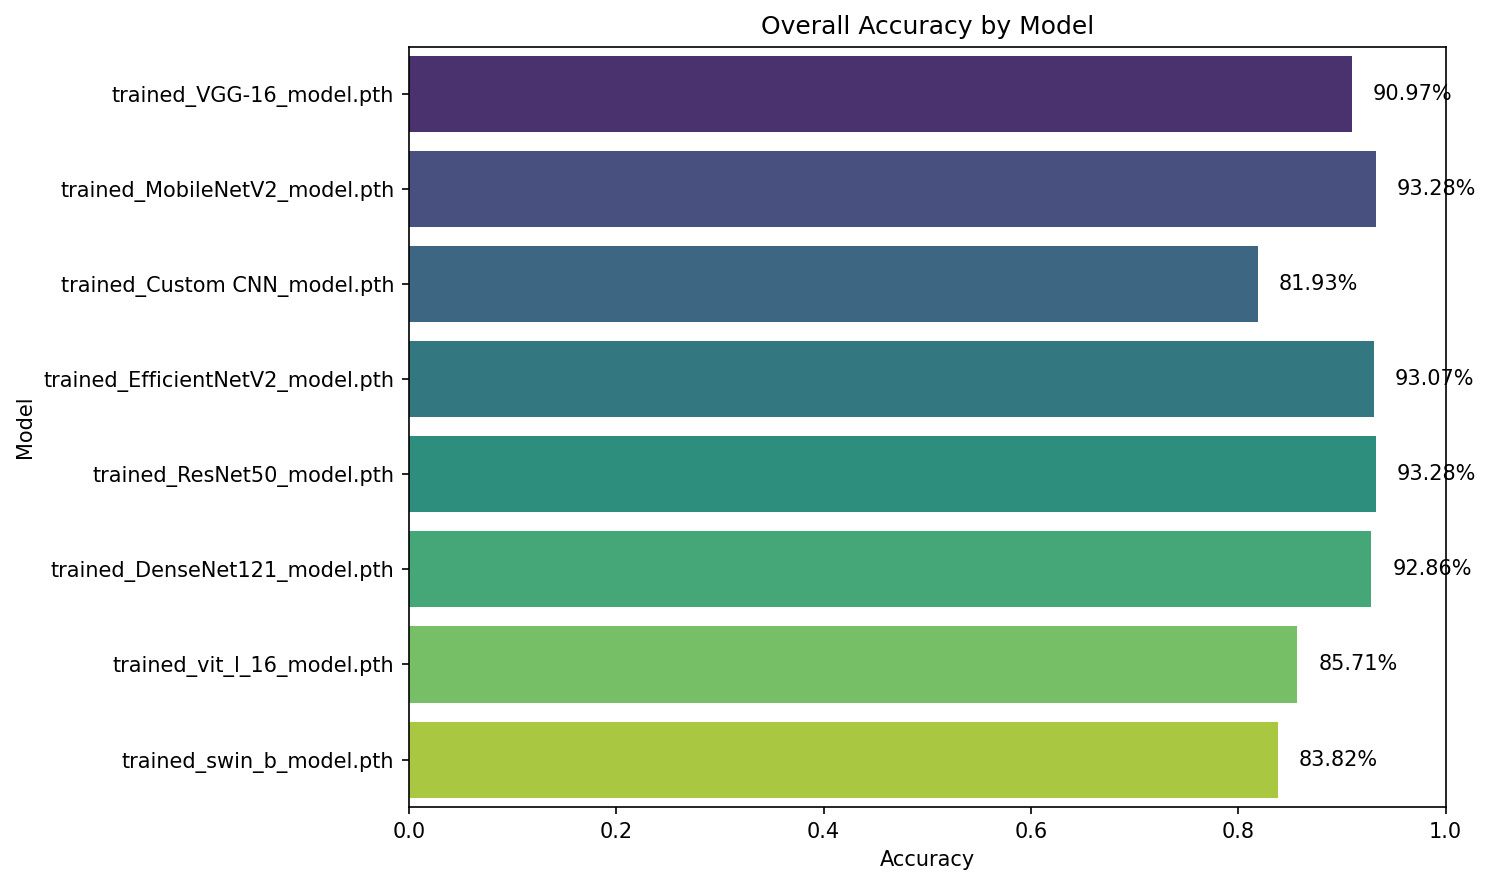

In [13]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from torchvision import models

# Set the path to the directory containing the models
models_path = "/kaggle/working/"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# List of class names
class_names = [
    'Cardboard', 
    'Food Organics', 
    'Glass', 
    'Metal', 
    'Miscellaneous Trash', 
    'Paper', 
    'Plastic', 
    'Textile Trash', 
    'Vegetation'
]

# Load the test loader (replace 'test_loader' with your actual DataLoader for testing)
# test_loader = ...

def load_model(model_path):
    """Load a model from a .pth file and return it."""
    if "efficient" in model_path.lower():
        model = models.efficientnet_v2_s(weights=None)
        in_features = model.classifier[-1].in_features
        model.classifier[-1] = nn.Linear(in_features, num_classes)
    elif "densenet121" in model_path.lower():
        model = models.densenet121(weights=None)
        model.classifier = torch.nn.Linear(model.classifier.in_features, len(class_names))
    elif "mobilenet" in model_path.lower():
        model = models.mobilenet_v2(weights=None)
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, len(class_names))
    elif "custom" in model_path.lower():
        model = CNNModel(num_classes=num_classes)
    elif "vit_l_16" in model_path.lower():
        model = models.vit_l_16(weights=None)
        model.heads.head = torch.nn.Linear(model.heads.head.in_features, len(class_names))
    elif "resnet50" in model_path.lower():
        model = models.resnet50(weights=None)
        model.fc = torch.nn.Linear(model.fc.in_features, len(class_names))
    elif "swin_b" in model_path.lower():
        model = models.swin_b(weights=None)
        model.head = torch.nn.Linear(model.head.in_features, len(class_names))
    elif "vgg-16" in model_path.lower():
        model = models.vgg16(weights=None)
        model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)
    else:
        raise ValueError(f"Unknown model type in file {model_path}")
    
    # Use weights_only=True to avoid security-related warnings
    model.load_state_dict(torch.load(model_path, map_location=device, weights_only=True))
    model.to(device)
    model.eval()
    return model

def evaluate_models(models_path, test_loader):
    """Evaluate all models and store predictions and labels."""
    model_files = [f for f in os.listdir(models_path) if f.endswith("model.pth")]
    results = {}
    for model_file in model_files:
        model_path = os.path.join(models_path, model_file)
        print(f"Evaluating model: {model_file}")
        model = load_model(model_path)
        all_preds, all_labels = [], []
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs, 1)
                all_preds.append(predicted.cpu().numpy())
                all_labels.append(labels.cpu().numpy())
        results[model_file] = {
            "preds": np.concatenate(all_preds),
            "labels": np.concatenate(all_labels)
        }
    return results

def plot_confusion_matrices(results):
    """Plot normalized confusion matrices (percentages) for all models with a maximum of three matrices per row."""
    num_models = len(results)
    cols = 3  # Max 3 confusion matrices per row
    rows = -(-num_models // cols)  # Round up division to calculate number of rows
    
    fig, axes = plt.subplots(rows, cols, figsize=(8 * cols, 8 * rows), dpi=150)
    axes = axes.flatten()  # Flatten axes array for easier indexing

    for i, (model_file, data) in enumerate(results.items()):
        # Compute confusion matrix and normalize it by row
        cm = confusion_matrix(data["labels"], data["preds"], normalize='true')
        cm_percentage = cm * 100  # Convert to percentage
        
        # Plot confusion matrix with percentages rounded to 1 decimal place
        sns.heatmap(cm_percentage, annot=True, fmt='.1f', cmap='Blues',
                    xticklabels=class_names, yticklabels=class_names, ax=axes[i])
        axes[i].set_title(f"Confusion Matrix (Normalized)\n{model_file}", fontsize=12)
        axes[i].set_xlabel("Predicted")
        axes[i].set_ylabel("True")
        axes[i].set_aspect('equal')  # Maintain aspect ratio

    # Remove unused axes if number of models is less than the grid size
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.savefig("confusion_matrices.png", dpi=300, bbox_inches="tight", format="png")
    plt.show()

def plot_classification_reports(results):
    """Plot classification reports for all models."""
    for model_file, data in results.items():
        report = classification_report(data["labels"], data["preds"], target_names=class_names)
        print(f"Classification Report for {model_file}:\n")
        print(report)
        print("\n" + "=" * 80 + "\n")

def plot_classification_metrics(results):
    """Plot precision, recall, and F1-score for all models with percentages on bars."""
    metrics = ['precision', 'recall', 'f1-score']
    for model_file, data in results.items():
        # Generate classification report as a dictionary
        report = classification_report(
            data["labels"], data["preds"], target_names=class_names, output_dict=True
        )
        
        # Extract metrics for each class (excluding 'accuracy' and 'macro avg')
        class_metrics = {metric: [] for metric in metrics}
        for class_name in class_names:
            for metric in metrics:
                class_metrics[metric].append(report[class_name][metric])
        
        # Convert class names to a numpy array to avoid Seaborn warnings
        class_array = np.array(class_names)

        # Plot metrics for the current model
        fig, axes = plt.subplots(1, 3, figsize=(18, 6), dpi=150)
        for ax, metric in zip(axes, metrics):
            # Create barplot
            sns.barplot(y=class_array, x=class_metrics[metric], ax=ax, palette="viridis")
            ax.set_title(f"{metric.capitalize()} by Class for {model_file}")
            ax.set_xlabel(metric.capitalize())
            ax.set_ylabel("Class")
            ax.set_xlim(0, 1)  # Scores are between 0 and 1

            # Add percentage labels inside bars
            for i, value in enumerate(class_metrics[metric]):
                ax.text(
                    value + 0.02, i, f"{value:.2%}", va="center", ha="left", fontsize=9
                )

        plt.tight_layout()
        # Save each model's figure with a different name
        plt.savefig(f"classification_metrics_{model_file}.png", dpi=300, bbox_inches="tight", format="png")
        plt.show()

def plot_model_accuracies(results):
    """Plot overall accuracy for all models."""
    accuracies = {}
    for model_file, data in results.items():
        # Generate classification report as a dictionary
        report = classification_report(
            data["labels"], data["preds"], target_names=class_names, output_dict=True
        )
        # Extract overall accuracy
        accuracies[model_file] = report['accuracy']
    
    # Convert model names to a numpy array to avoid warnings
    model_names = np.array(list(accuracies.keys()))
    accuracy_values = list(accuracies.values())

    plt.figure(figsize=(10, 6), dpi=150)
    sns.barplot(x=accuracy_values, y=model_names, palette="viridis")
    plt.title("Overall Accuracy by Model")
    plt.xlabel("Accuracy")
    plt.ylabel("Model")
    plt.xlim(0, 1)  # Accuracy is between 0 and 1

    # Add percentage labels inside bars
    for i, value in enumerate(accuracy_values):
        plt.text(
            value + 0.02, i, f"{value:.2%}", va="center", ha="left", fontsize=10
        )

    plt.tight_layout()
    plt.savefig("model_accuracies.png", dpi=300, bbox_inches="tight", format="png")
    plt.show()

# Evaluation and plotting
results = evaluate_models(models_path, test_loader)
plot_confusion_matrices(results)
plot_classification_reports(results)
plot_classification_metrics(results)
plot_model_accuracies(results)

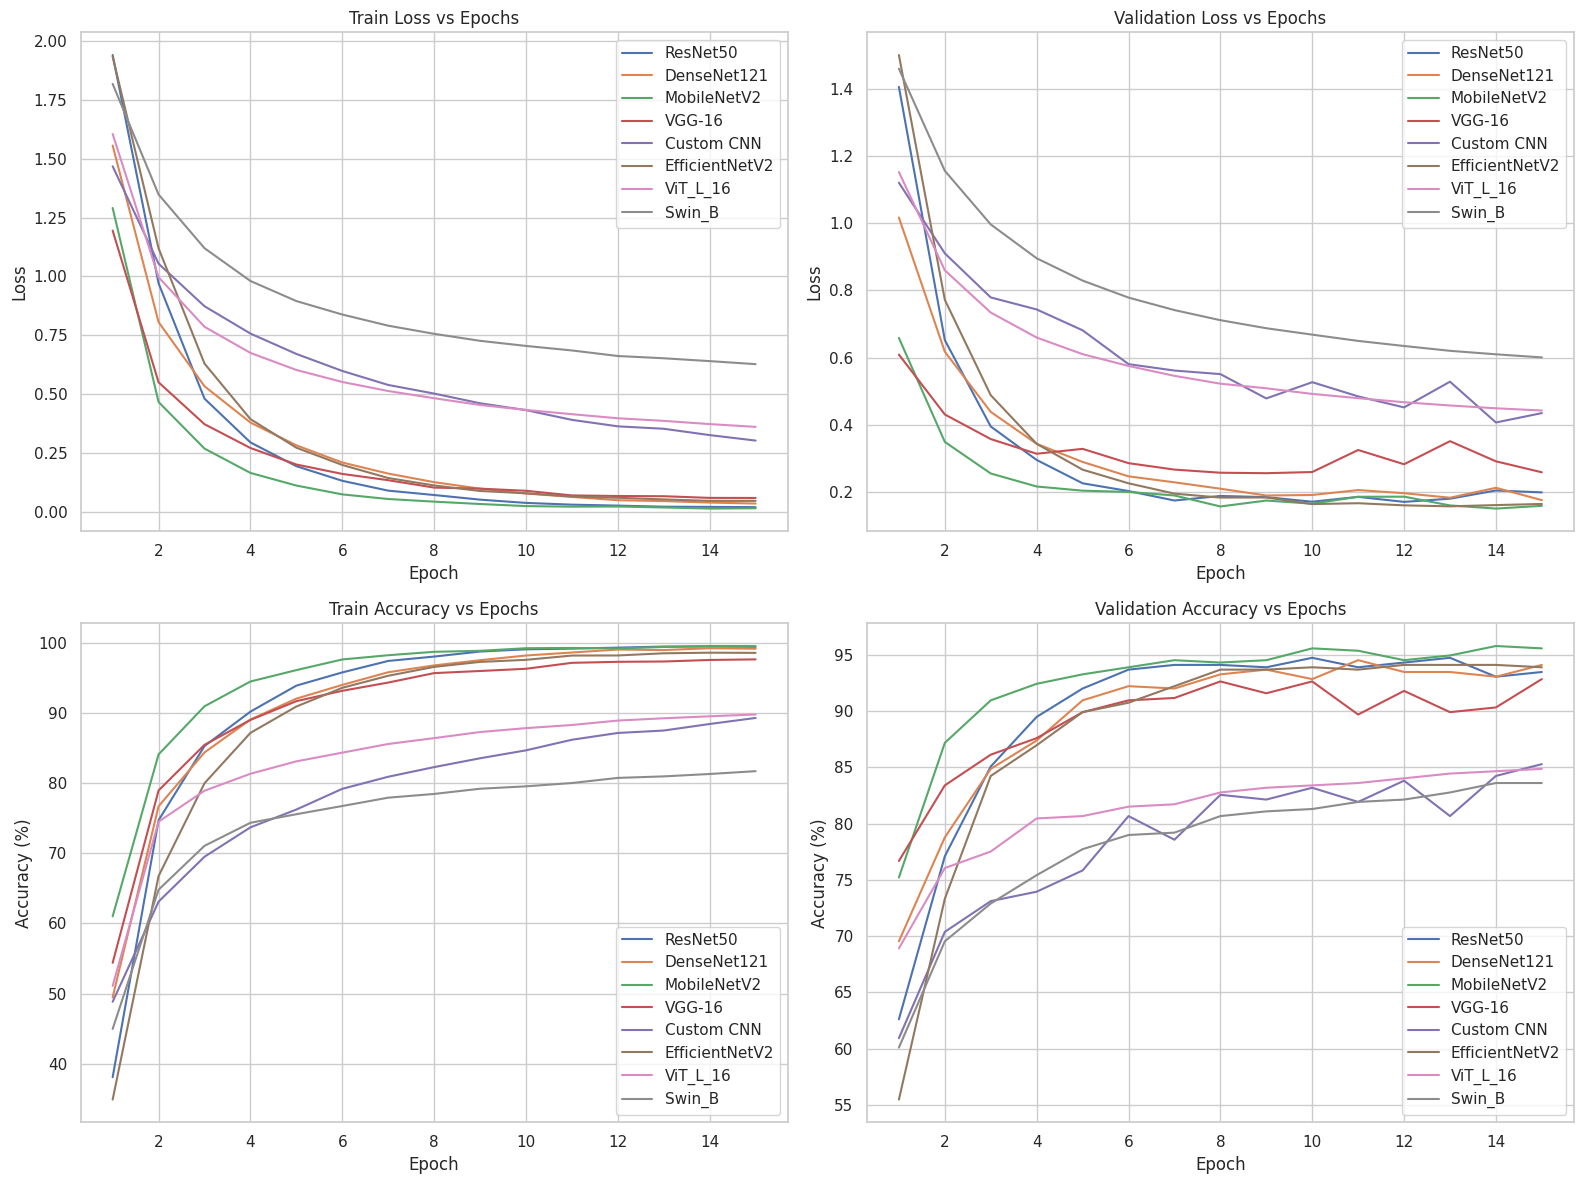

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set Seaborn style
sns.set_theme(style="whitegrid")

# Load the CSV file to inspect its structure
file_path = 'training_results.csv'
data = pd.read_csv(file_path)

# Unique models in the dataset
models = data['model_name'].unique()

# Create subplots for separate metrics
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

# Plot Train Loss
for model in models:
    model_data = data[data['model_name'] == model]
    axes[0].plot(model_data['epoch'], model_data['train_loss'], label=f'{model}')
axes[0].set_title("Train Loss vs Epochs")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].legend()

# Plot Validation Loss
for model in models:
    model_data = data[data['model_name'] == model]
    axes[1].plot(model_data['epoch'], model_data['val_loss'], label=f'{model}')
axes[1].set_title("Validation Loss vs Epochs")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Loss")
axes[1].legend()

# Plot Train Accuracy
for model in models:
    model_data = data[data['model_name'] == model]
    axes[2].plot(model_data['epoch'], model_data['train_accuracy'], label=f'{model}')
axes[2].set_title("Train Accuracy vs Epochs")
axes[2].set_xlabel("Epoch")
axes[2].set_ylabel("Accuracy (%)")
axes[2].legend()

# Plot Validation Accuracy
for model in models:
    model_data = data[data['model_name'] == model]
    axes[3].plot(model_data['epoch'], model_data['val_accuracy'], label=f'{model}')
axes[3].set_title("Validation Accuracy vs Epochs")
axes[3].set_xlabel("Epoch")
axes[3].set_ylabel("Accuracy (%)")
axes[3].legend()

# Adjust layout for better readability
plt.tight_layout()
plt.savefig("train_validation_accuracies.png", dpi=300, bbox_inches="tight", format="png")
plt.show()

### Function: `plot_misclassified_images`

The `plot_misclassified_images` function provides a visual understanding of where and why the model makes errors in classification. Specifically, it identifies and displays misclassified samples from the test dataset for a selected model.

#### Key Features:
1. **Model and Results:** It requires the model's predictions (`results`) and true labels from the test dataset.
2. **Customizable Display:** Users can select a specific class (`selected_class`) to focus on either by true labels (`mode="true"`) or predicted labels (`mode="pred"`). Additionally, the number of samples displayed can be controlled using the `num_samples` parameter.
3. **Visualization:** Misclassified images are displayed in a grid format, showing their true labels and the incorrect predictions. This aids in understanding the model's weaknesses and the inherent challenges in the dataset.

This function is particularly useful for interpreting the performance of classification models, especially in complex datasets like waste classification, where certain objects may inherently resemble others.

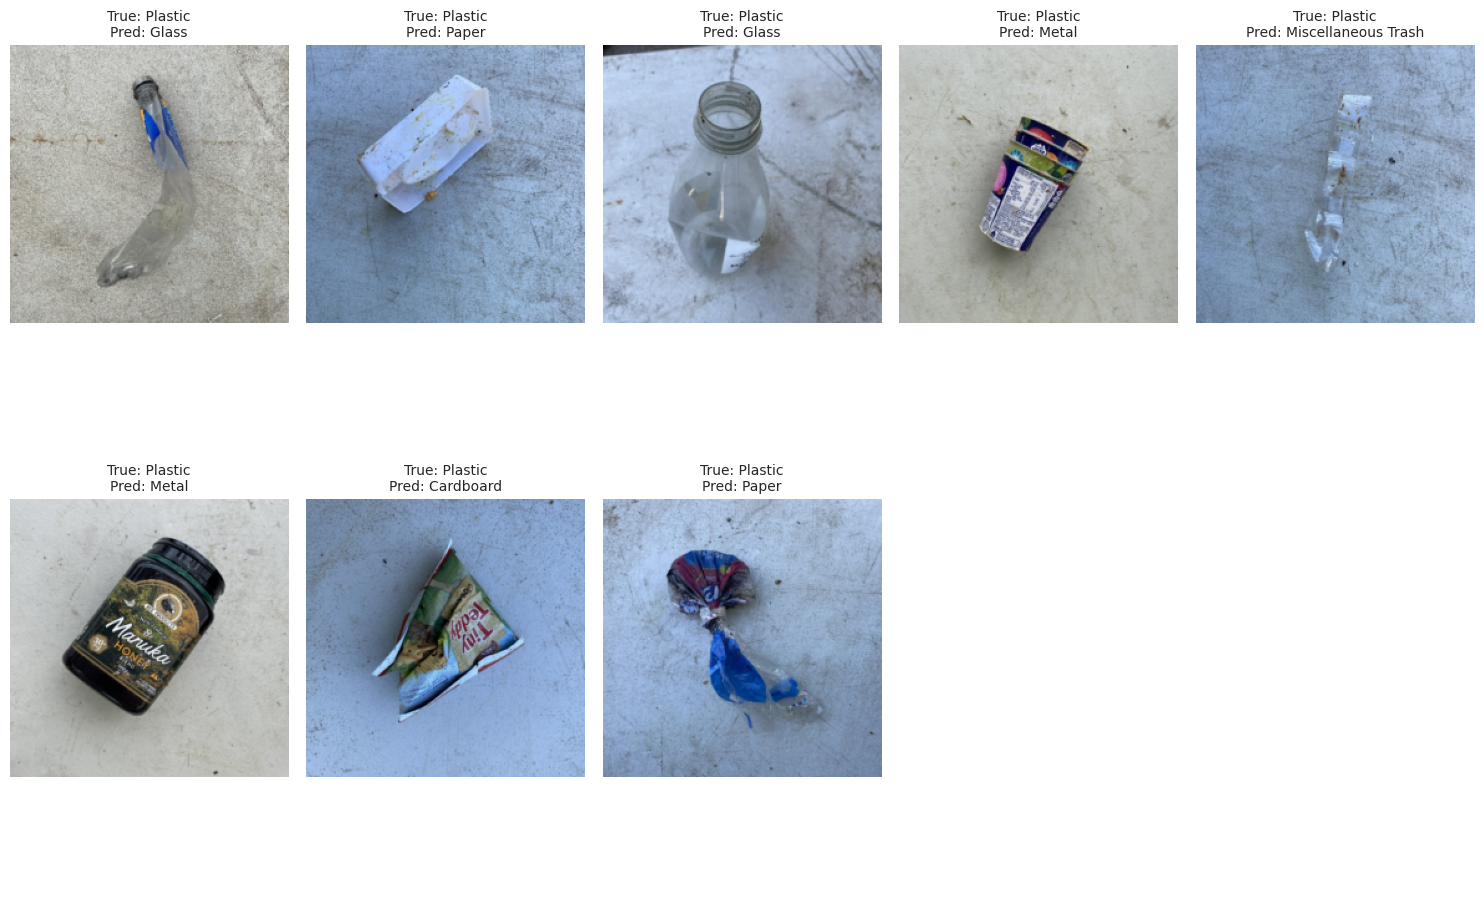

In [27]:
def plot_misclassified_images(model_name, results, test_loader, num_samples=10, selected_class=None, mode="true"):
    """
    Plot misclassified images for a selected model.
    
    Args:
        model_name (str): Name of the model to evaluate (e.g., "mobilenetv2").
        results (dict): Dictionary containing predictions and labels for each model.
        test_loader (DataLoader): DataLoader for the test dataset.
        num_samples (int): Number of misclassified samples to display.
        selected_class (int or None): The target class to filter (True label or Predicted label).
        mode (str): "true" to filter by true label, "pred" to filter by predicted label.
    """
    assert mode in ["true", "pred"], "Mode must be 'true' or 'pred'"
    
    # Extract predictions and true labels
    preds = results[model_name]["preds"]
    labels = results[model_name]["labels"]
    
    # Identify misclassified samples
    misclassified_idx = np.where(preds != labels)[0]
    misclassified_preds = preds[misclassified_idx]
    misclassified_labels = labels[misclassified_idx]
    
    # Filter by the selected class if provided
    if selected_class is not None:
        if mode == "true":
            mask = misclassified_labels == selected_class
        elif mode == "pred":
            mask = misclassified_preds == selected_class
        filtered_idx = misclassified_idx[mask]
    else:
        filtered_idx = misclassified_idx
    
    # Limit the number of samples to display
    if len(filtered_idx) > num_samples:
        selected_indices = np.random.choice(filtered_idx, num_samples, replace=False)
    else:
        selected_indices = filtered_idx
    
    # Calculate grid dimensions
    cols = 5  # Max 5 images per row
    rows = -(-len(selected_indices) // cols)  # Round up division for rows
    
    # Plot the misclassified images
    fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows))
    axes = axes.flatten()  # Flatten axes array for easier iteration
    
    for ax, idx in zip(axes, selected_indices):
        # Retrieve the original image and true/predicted labels
        image, true_label = test_loader.dataset[idx]
        image = image.permute(1, 2, 0).numpy()  # Convert to HWC format
        true_label = class_names[true_label]
        pred_label = class_names[preds[idx]]
        
        # Plot the image
        ax.imshow(image)
        ax.set_title(f"True: {true_label}\nPred: {pred_label}", fontsize=10)
        ax.axis("off")
    
    # Turn off any unused axes
    for ax in axes[len(selected_indices):]:
        ax.axis("off")
    
    plt.tight_layout()
    plt.show()


#0: 'Cardboard',
#1: 'Food Organics',
#2: 'Glass',
#3: 'Metal',
#4: 'Miscellaneous Trash',
#5: 'Paper',
#6: 'Plastic',
#7: 'Textile Trash',
#8: 'Vegetation'

# Shows the misclassified images
plot_misclassified_images(
    model_name="trained_MobileNetV2_model.pth",
    results=results,
    test_loader=test_loader,
    num_samples=50,
    selected_class=6,  # Selected class
    mode="true"  # Filter by True labels
)

### Observations from Misclassification Analysis

The analysis of misclassified samples reveals that the model demonstrates a solid understanding of the waste classification problem. It effectively captures the key features of objects across various categories, indicating strong generalization capabilities. However, the model also exhibits certain limitations, which stem from the inherent complexities of waste classification:

1. **Visual Similarities:** 
   - Glass and plastic bottles often appear similar in shape and texture.
   - Paper and cardboard share visual characteristics that can be challenging to distinguish, even for humans.

2. **Mixed-Class Objects:**
   - Items in the "Miscellaneous Trash" category frequently consist of multiple materials (e.g., plastic, metal, and paper), making them prone to misclassification.

3. **Dataset Limitations:** 
   - The accuracy of the model could be further improved with the addition of more diverse and representative training data, particularly for underrepresented or ambiguous categories.

Overall, the model performs admirably, generalizing well and classifying objects effectively across most categories. Addressing these inherent challenges with enriched training data and advanced techniques would likely enhance its predictive performance further.

## Authors

- **Alessio Lani** 1857003
- **Enrico Giordani** 2143412
- **Lorenzo Arcioni** 1885377
- **Marta Lombardi** 2156537
- **Valeria Avino** 1905974